# Welcome to Passion!
Passion is a model that can detection anomaly using different methods (Both supervised and unsupervised) <br>

1. The goal for this project is to study the difference between different anomnaly detection model, and to   <br>
 find the state of art method for detecting anomaly in real world data<br>
2. Evaluate the results based on this :real server data+ https://www.kaggle.com/sohier/30-years-of-european-wind-generation (Unsupervised)+ https://github.com/numenta/NAB (Unsupervised+Supervised)  https://www.cs.ucr.edu/~eamonn/time_series_data/ (Supervised) <br>
3. Also use real data generated from server.
4. The model has the following fuctions: <br>
    a. Visualize the input data. Help the user to find critical features within the inputs. <br>
    b. Give user options to choose different models that are suitable for different circumstances. <br>
    c. Evaluate the performance based on the rules in this link https://github.com/numenta/NAB <br>
    d. Save model. Easy to be appplied to other dataset. <br>

## Outline:
1. Data visualization
2. Traditional machine learning models
3. Deep learning models
4. Reinforcement learning models
5. Summary






In [1]:
# import packages 


from matplotlib.pylab import rc
import torch
from scipy.stats import chisquare
from scipy.stats import pearsonr 
import pickle
import pandas as pd
import datetime
import matplotlib
import tensorflow as tf
import sklearn
import math
import matplotlib.pyplot as plt
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
import numpy as np
from sklearn.model_selection import train_test_split 
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder 
import copy
import scipy
import datetime
import time
import os
from sklearn.model_selection import KFold 
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import gc
import json
plot_path = "plots/"




In [2]:

# Real server data (Unsupervised)

root_path = "Data/Ant_202007/"


cif = pd.read_json(root_path+'cif.json', orient='index')
paycore = pd.read_json(root_path+'paycore.json', orient='index')
paydecision = pd.read_json(root_path+'paydecision.json', orient='index')
paydecision2 = pd.read_json(root_path+'paydecision2.json', orient='index')
paydecision3 = pd.read_json(root_path+'paydecision3.json', orient='index')

df = pd.DataFrame()
df["time_stamp"] = cif.index
df["cif"] = cif[0].values
df["paycore"] = paycore[0].values
df["paydecision"] = paydecision[0].values
df["paydecision2"] = paydecision2[0].values
df["paydecision3"] = paydecision3[0].values

# Optional
if False:
    df.to_csv(root_path+"fusion.csv")

    
# convert time stamp
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
names_array = np.array(df.keys()[1:],dtype="str")
os.listdir(root_path)






['.ipynb_checkpoints',
 'cif.json',
 'fusion.csv',
 'paycore.json',
 'paydecision.json',
 'paydecision2.json',
 'paydecision3.json']

In [9]:
if False:
    
    # calculate previous hour high low:
    # convert to seconds
    temp = df['time_stamp'] - min(df['time_stamp'])
    temp = temp.dt.total_seconds().astype(int)
    df["hours"] = temp//3600

    h_max = max(df["hours"])+1

    for n in range(len(names_array)):
        df[names_array[n]+"_open"] = df[names_array[n]]
        df[names_array[n]+"_close"] = df[names_array[n]]
        df[names_array[n]+"_max"] = df[names_array[n]]
        df[names_array[n]+"_min"] = df[names_array[n]]

    for j in range(1,h_max):
        mask_j = df["hours"]==j-1
        max_val = df[mask_j][names_array].max(axis=0).values
        min_val = df[mask_j][names_array].max(axis=0).values
        open_val = df[mask_j][names_array].values[0,:]
        close_val = df[mask_j][names_array].values[-1,:]
        mask_i = df["hours"]==j
        r = df[mask_i][names_array].shape[0]
        df.loc[mask_i,[r+"_open" for r in names_array]] = np.tile(open_val,(r,1))
        df.loc[mask_i,[r+"_close" for r in names_array]] = np.tile(close_val,(r,1))

        df.loc[mask_i,[r+"_max" for r in names_array]] = np.tile(max_val,(r,1))
        df.loc[mask_i,[r+"_min" for r in names_array]] = np.tile(min_val,(r,1))
    
    


names_array = list(df.keys())[1:]

In [10]:
df.head()

time_stamp        cif  paycore  paydecision  paydecision2  \
0 2020-06-03 16:00:00  5230362.0  1742333       810511        894642   
1 2020-06-03 16:01:00  5430718.0  1250771       732380        720773   
2 2020-06-03 16:02:00  5352478.0   998340       715939        691644   
3 2020-06-03 16:03:00  5247694.0   971876       701533        669921   
4 2020-06-03 16:04:00  5197260.0   926380       685236        649162   

   paydecision3  
0        254995  
1        213345  
2        163959  
3        165899  
4        167605

## Part1: Data Visualization


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


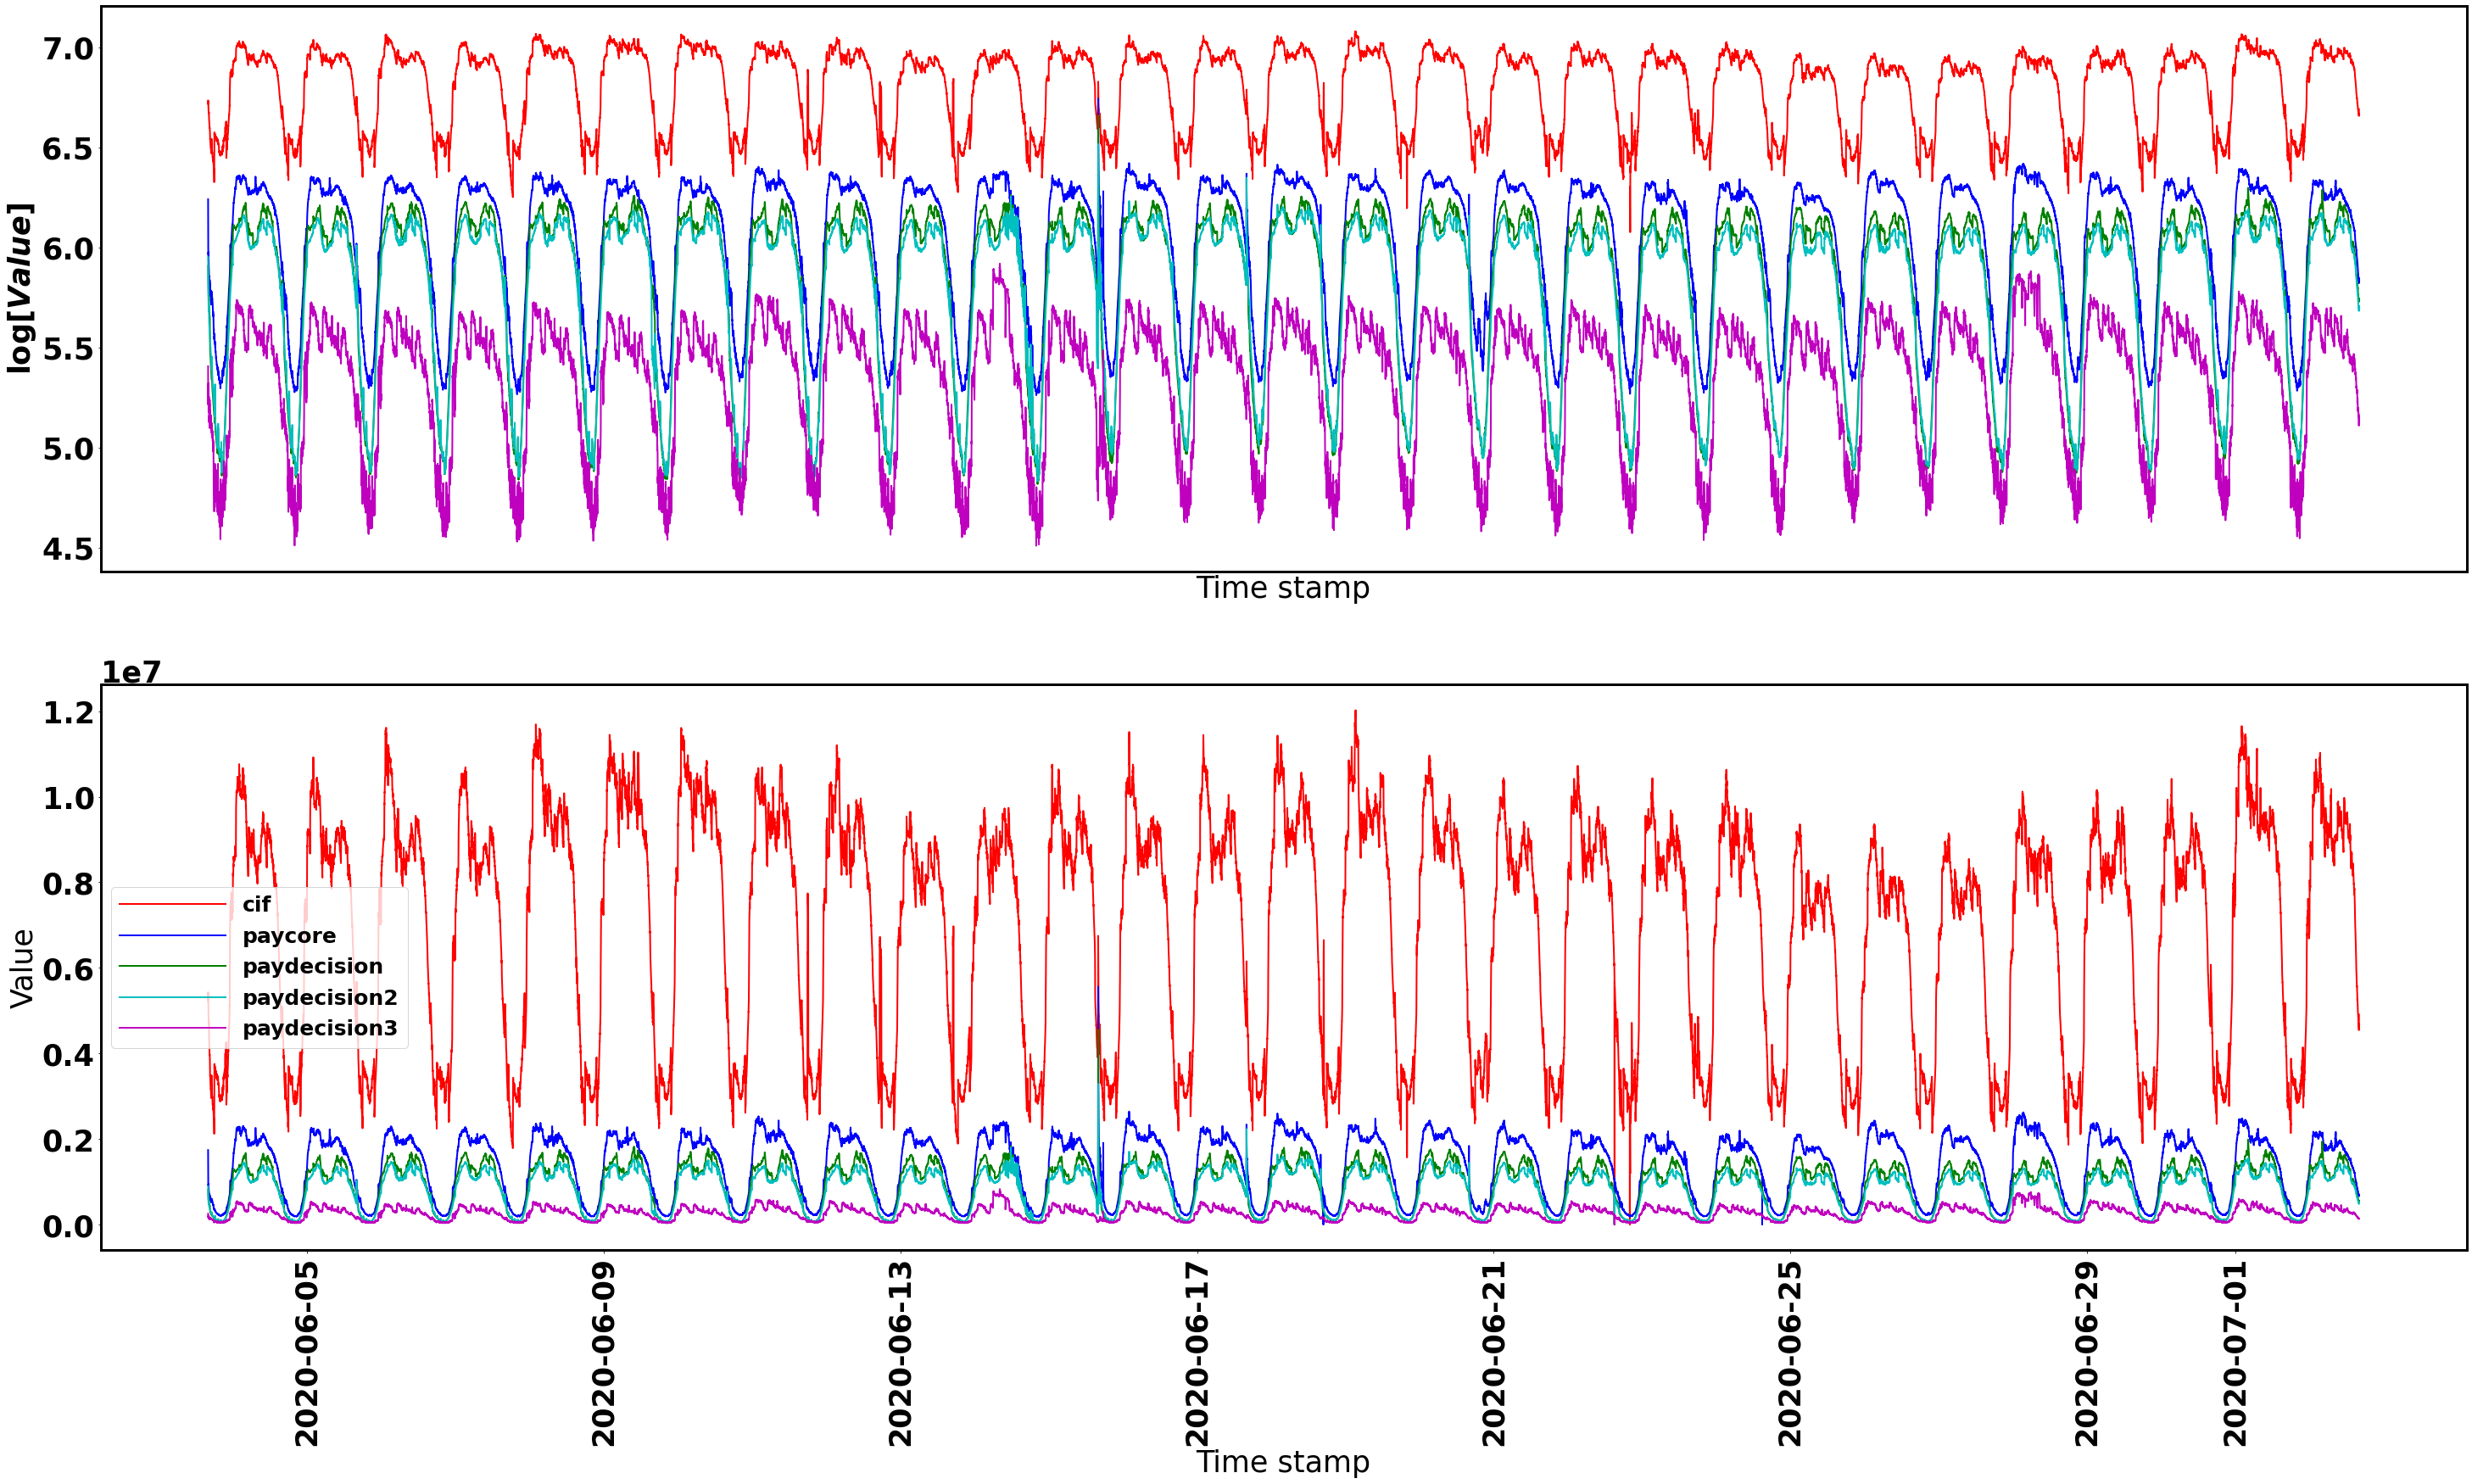

In [11]:
# A rough visualization of the data
import warnings
warnings.filterwarnings('ignore')


color_array = ['r', 'b', 'g', 'c', 'm', 'y', 'k']

from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 35}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


plt.subplot(2,1,1)


for i in range(len(names_array)):
    plt.plot(df['time_stamp'],np.log10(df[names_array[i]]),color_array[i],label=names_array[i],linewidth=2,markersize=5)
    



plt.xlabel("Time stamp")
plt.ylabel(r"$\log[Value]$")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.subplot(2,1,2)


for i in range(len(names_array)):
    plt.plot(df['time_stamp'],df[names_array[i]],color_array[i],label=names_array[i],linewidth=2,markersize=5)
    


plt.xticks(rotation=90)


plt.xlabel("Time stamp")
plt.ylabel(r"Value")


fig = matplotlib.pyplot.gcf()


fig.set_size_inches(50,27)
plt.legend(fontsize=25,handlelength=5)

save_path = plot_path + "Data_server_original" + ".png"

fig.savefig(save_path, dpi=300)




findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


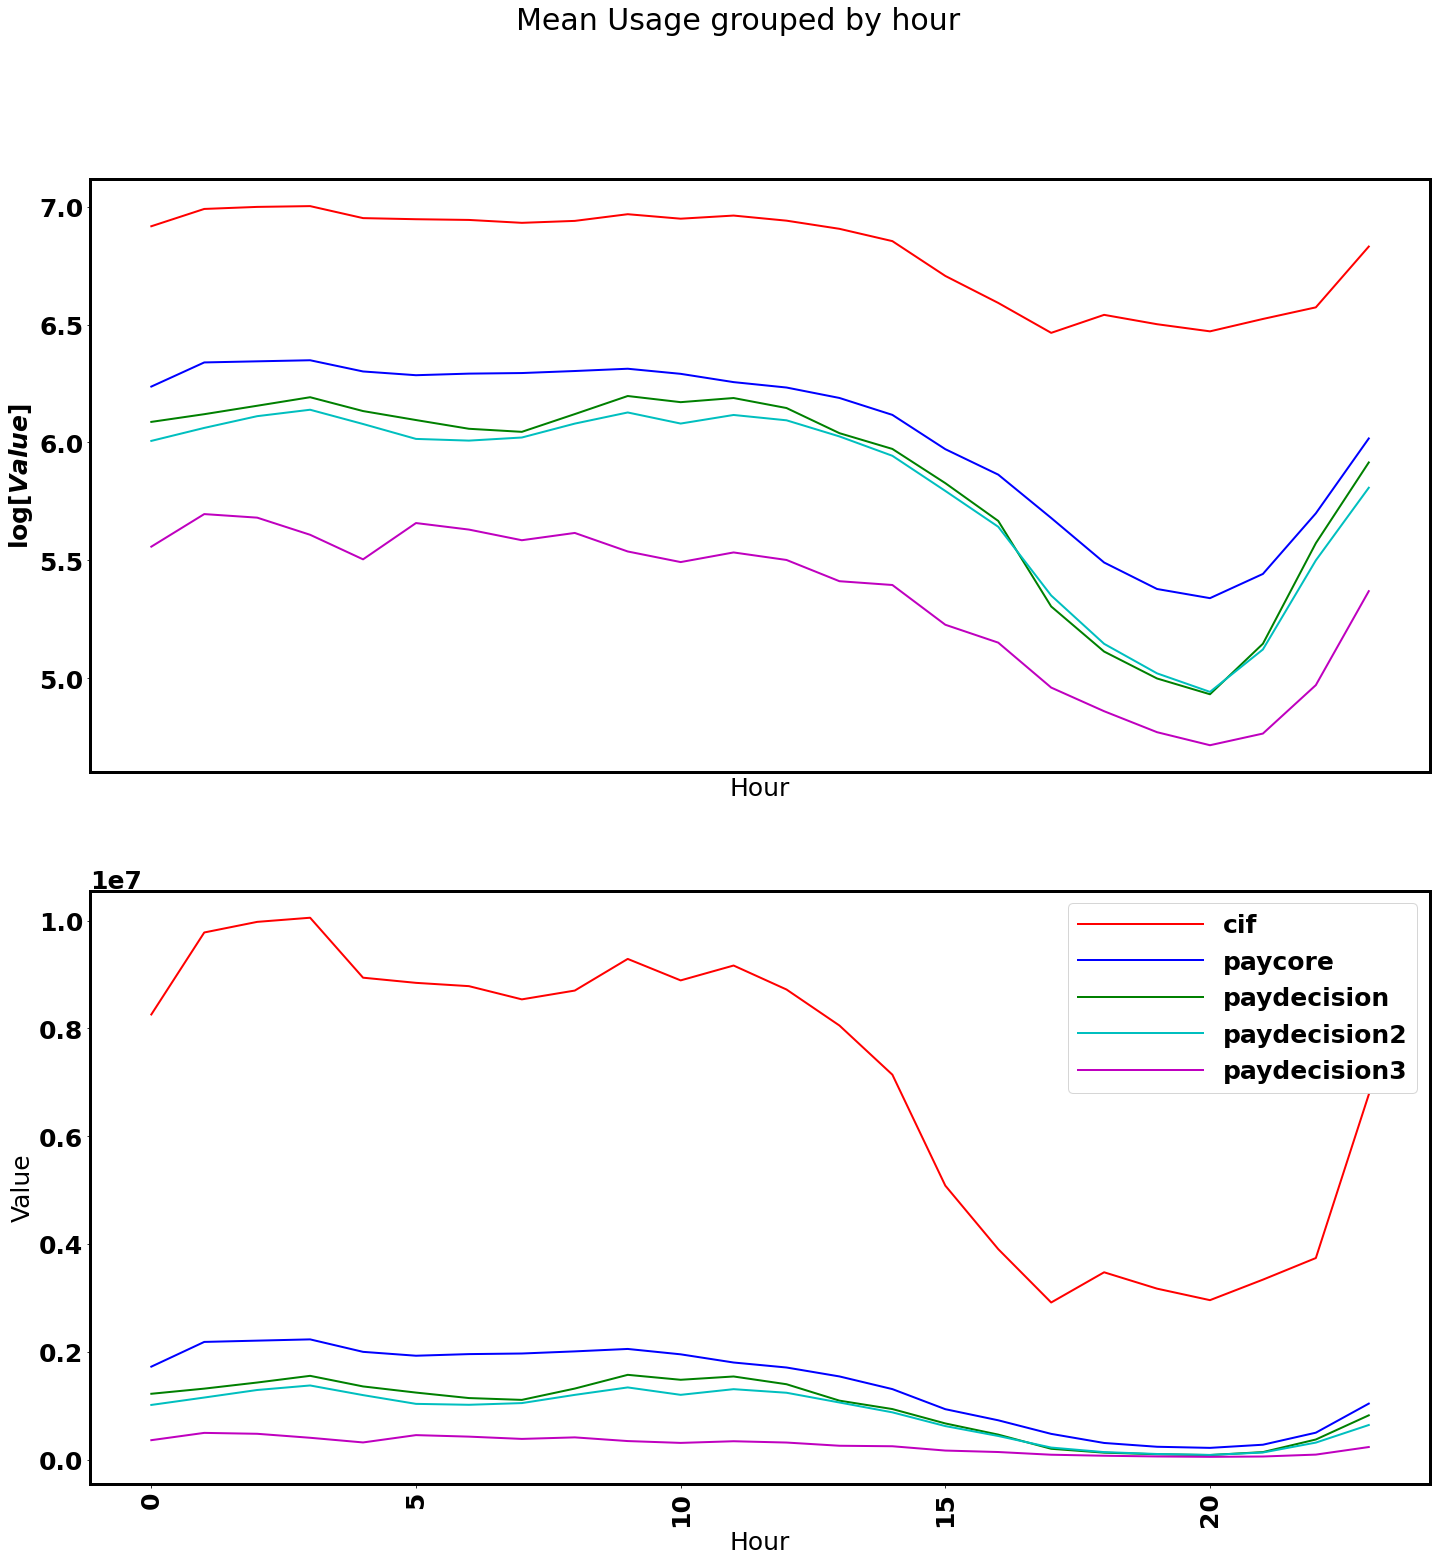

In [12]:
## group by hours
# A rough visualization of the data
import warnings
warnings.filterwarnings('ignore')


df['hours'] = df['time_stamp'].dt.hour

color_array = ['r', 'b', 'g', 'c', 'm', 'y', 'k']

from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


plt.subplot(2,1,1)



for i in range(len(names_array)):
    plt.plot(df.groupby('hours').mean().index,np.log10(df.groupby('hours').mean()[names_array[i]]),color_array[i],label=names_array[i],linewidth=2,markersize=5)
    




plt.xlabel("Hour")
plt.ylabel(r"$\log[Value]$")
plt.suptitle("Mean Usage grouped by hour")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.subplot(2,1,2)


for i in range(len(names_array)):
    plt.plot(df.groupby('hours').mean().index,df.groupby('hours').mean()[names_array[i]],color_array[i],label=names_array[i],linewidth=2,markersize=5)
    


plt.xticks(rotation=90)


plt.xlabel("Hour")
plt.ylabel(r"Value")
plt.suptitle("Mean Usage grouped by hour")


fig = matplotlib.pyplot.gcf()


fig.set_size_inches(24,24)
plt.legend(fontsize=25,handlelength=5)
save_path = plot_path + "Data_server_original_group_by_hour" + ".png"

fig.savefig(save_path, dpi=300)





Doing cif
Doing paycore
Doing paydecision
Doing paydecision2
Doing paydecision3


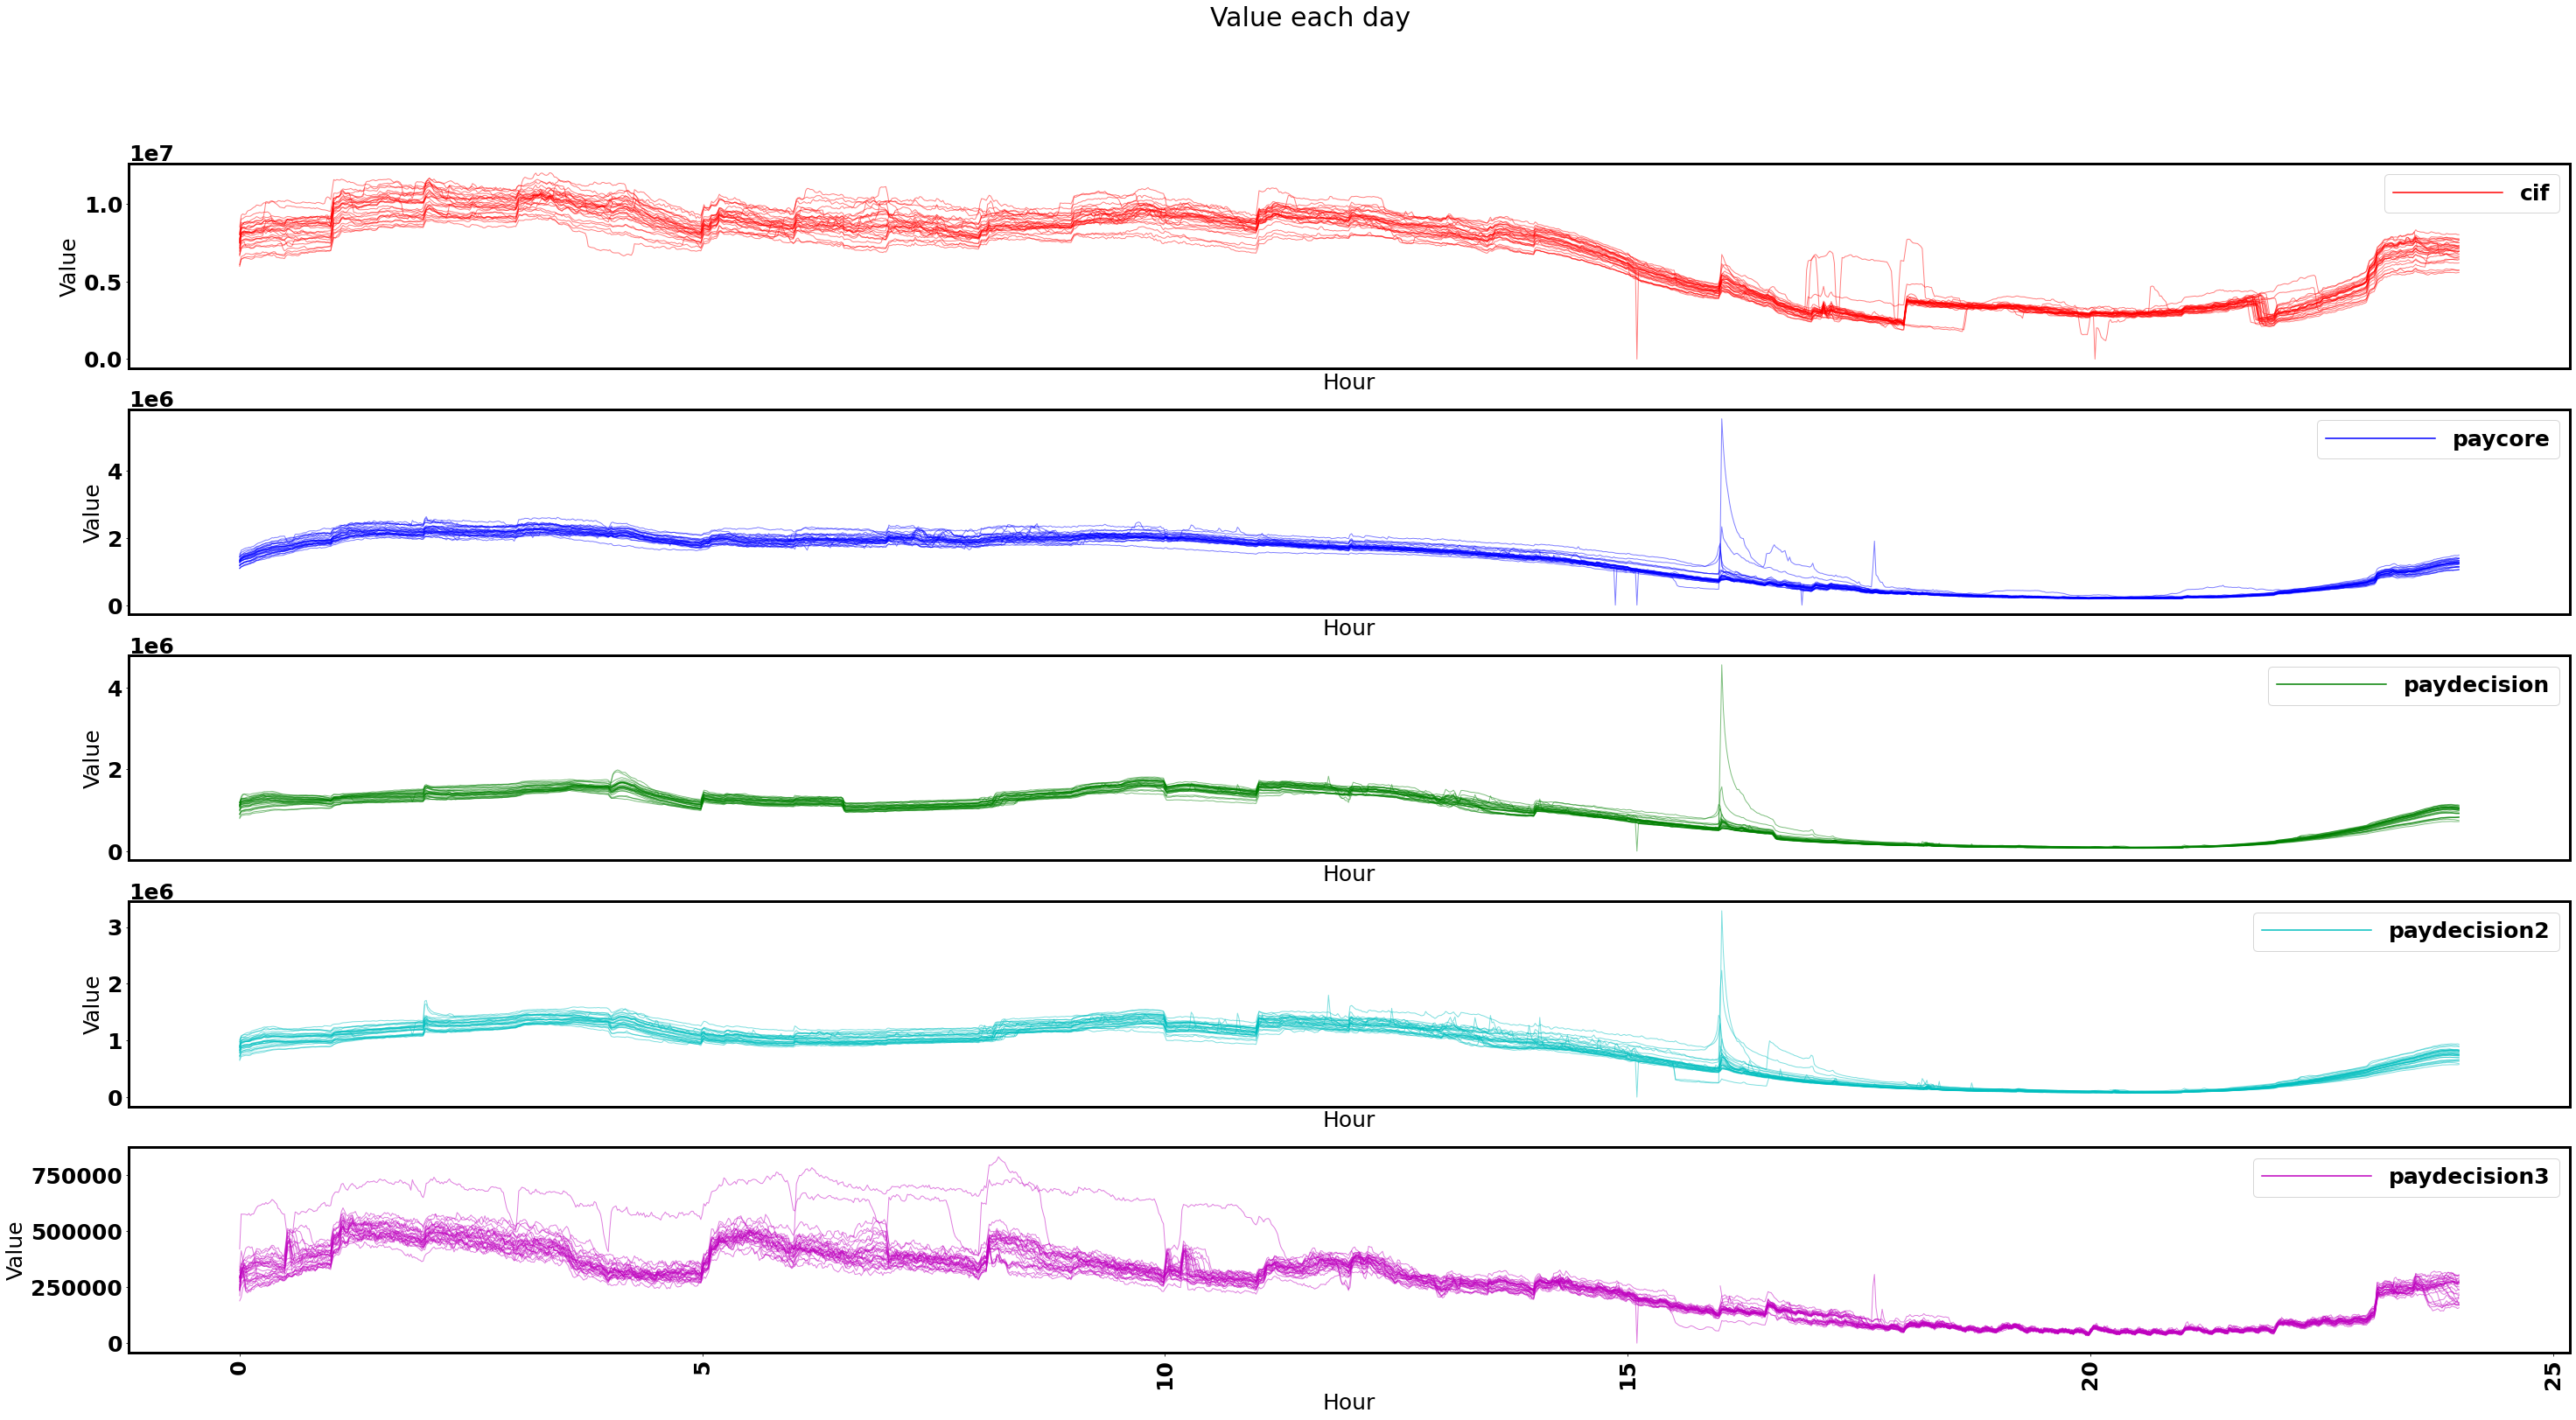

In [13]:
# Another plot: data for each day:
df['days'] = df['time_stamp'].dt.day

    
## group by hours
# A rough visualization of the data
import warnings
warnings.filterwarnings('ignore')




df["hours_float"] =df['time_stamp'].dt.hour + df['time_stamp'].dt.minute/60

color_array = ['r', 'b', 'g', 'c', 'm', 'y', 'k']

from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)






for i in range(len(names_array)):
    plt.subplot(len(names_array),1,i+1)
    print("Doing %s"%names_array[i])
    plt.plot([],[],color_array[i],label=names_array[i])
    for j in range(1,31):
        mask_d = df['days']==j
        plt.plot(df["hours_float"][mask_d],df[names_array[i]][mask_d],color_array[i],linewidth=1,alpha=0.5)
    plt.xlabel("Hour")
    plt.ylabel(r"Value")
    plt.suptitle("Mean Usage grouped by hour")
    if i<len(names_array)-1:
        plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    else:
        plt.xticks(rotation=90)
        
    plt.legend(fontsize=25,handlelength=5)
        




plt.suptitle("Value each day")


fig = matplotlib.pyplot.gcf()


fig.set_size_inches(50,25)

save_path = plot_path + "Data_server_each_day" + ".png"

fig.savefig(save_path, dpi=200)




    

Doing cif
Doing paycore
Doing paydecision
Doing paydecision2
Doing paydecision3


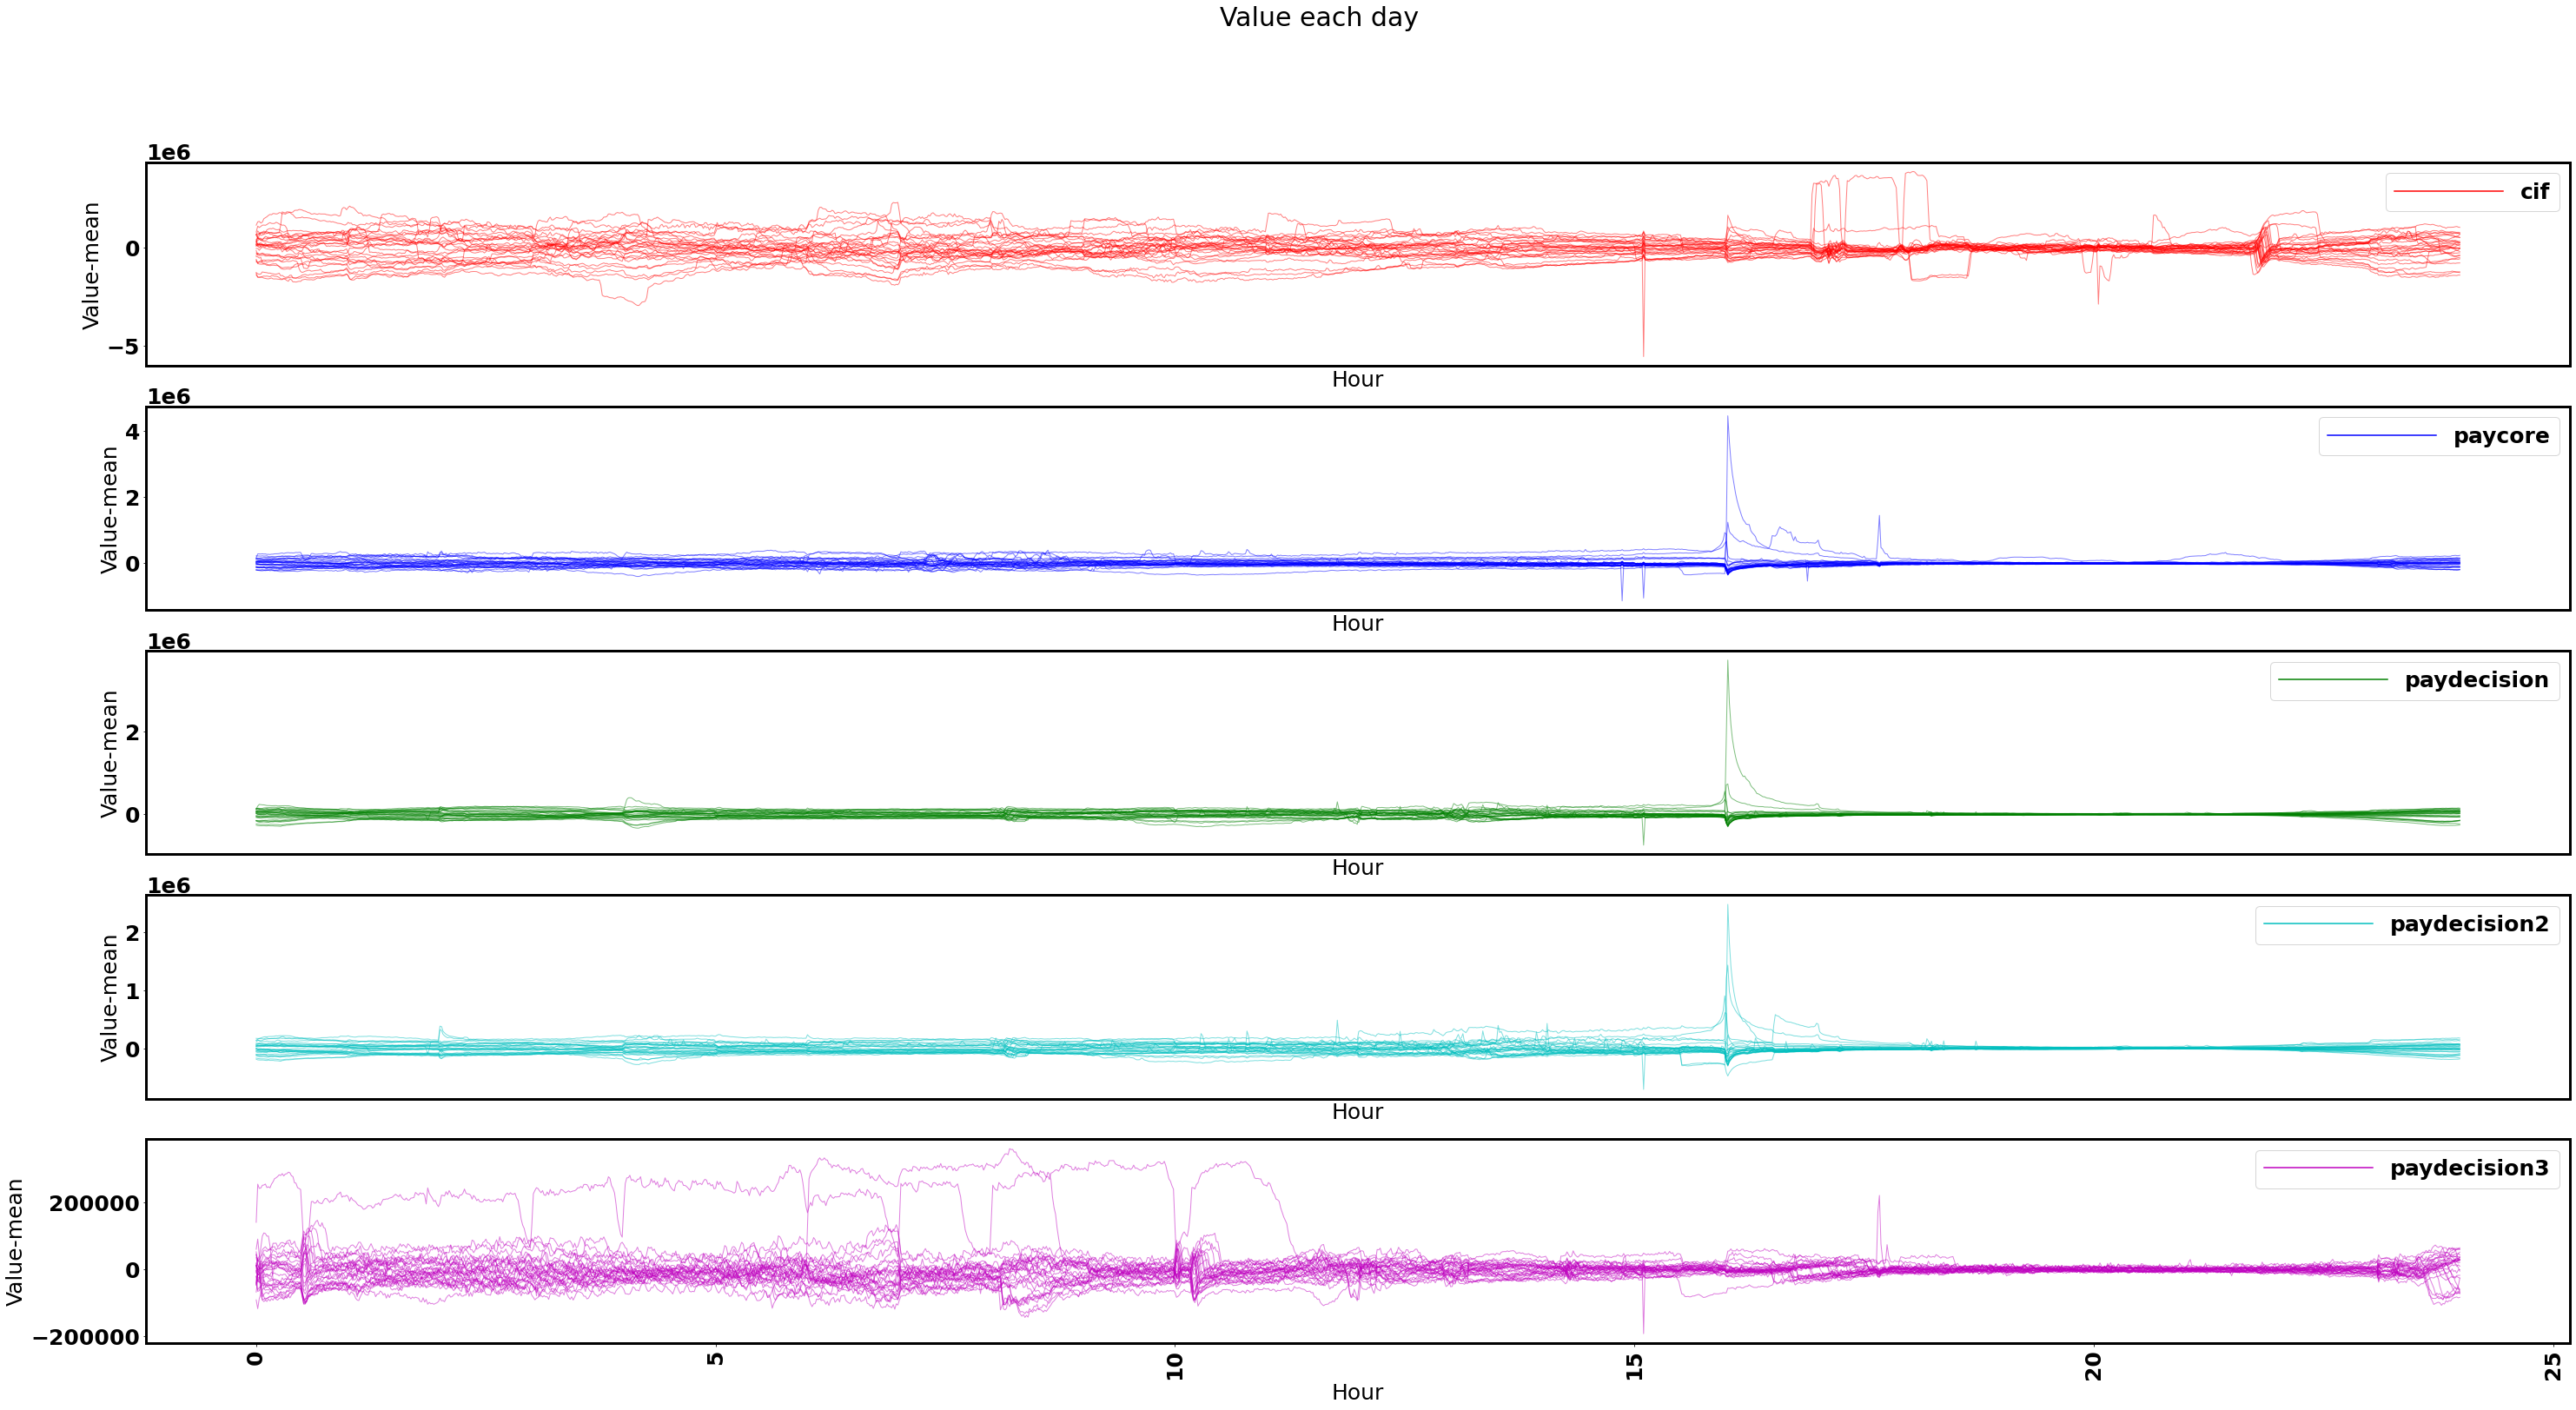

In [14]:
# Another plot: data for each day minus mean each day
df['days'] = df['time_stamp'].dt.day

    
## group by hours
# A rough visualization of the data
import warnings
warnings.filterwarnings('ignore')




df["hours_float"] =df['time_stamp'].dt.hour + df['time_stamp'].dt.minute/60

color_array = ['r', 'b', 'g', 'c', 'm', 'y', 'k']

from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)






for i in range(len(names_array)):
    plt.subplot(len(names_array),1,i+1)
    print("Doing %s"%names_array[i])
    plt.plot([],[],color_array[i],label=names_array[i])
    offset = np.array(df.groupby("hours_float").mean()[names_array[i]])
    for j in range(1,31):
        mask_d = df['days']==j
        try:
            plt.plot(df["hours_float"][mask_d],df[names_array[i]][mask_d]-offset,color_array[i],linewidth=1,alpha=0.5)
        except:
            pass
    plt.xlabel("Hour")
    plt.ylabel(r"Value-mean")
    plt.suptitle("Mean Usage grouped by hour minus mean")
    if i<len(names_array)-1:
        plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    else:
        plt.xticks(rotation=90)
        
    plt.legend(fontsize=25,handlelength=5)
        




plt.suptitle("Value each day")


fig = matplotlib.pyplot.gcf()


fig.set_size_inches(50,25)

save_path = plot_path + "Data_server_each_day_minus_mean" + ".png"

fig.savefig(save_path, dpi=200)




    

# Baseline model: Isolation Forest (Traditional machine learning model)



cif 0    40508
1     1253
Name: anomaly_iforest_cif, dtype: int64
paycore 0    40510
1     1251
Name: anomaly_iforest_paycore, dtype: int64
paydecision 0    40520
1     1241
Name: anomaly_iforest_paydecision, dtype: int64
paydecision2 0    40511
1     1250
Name: anomaly_iforest_paydecision2, dtype: int64
paydecision3 0    40517
1     1244
Name: anomaly_iforest_paydecision3, dtype: int64


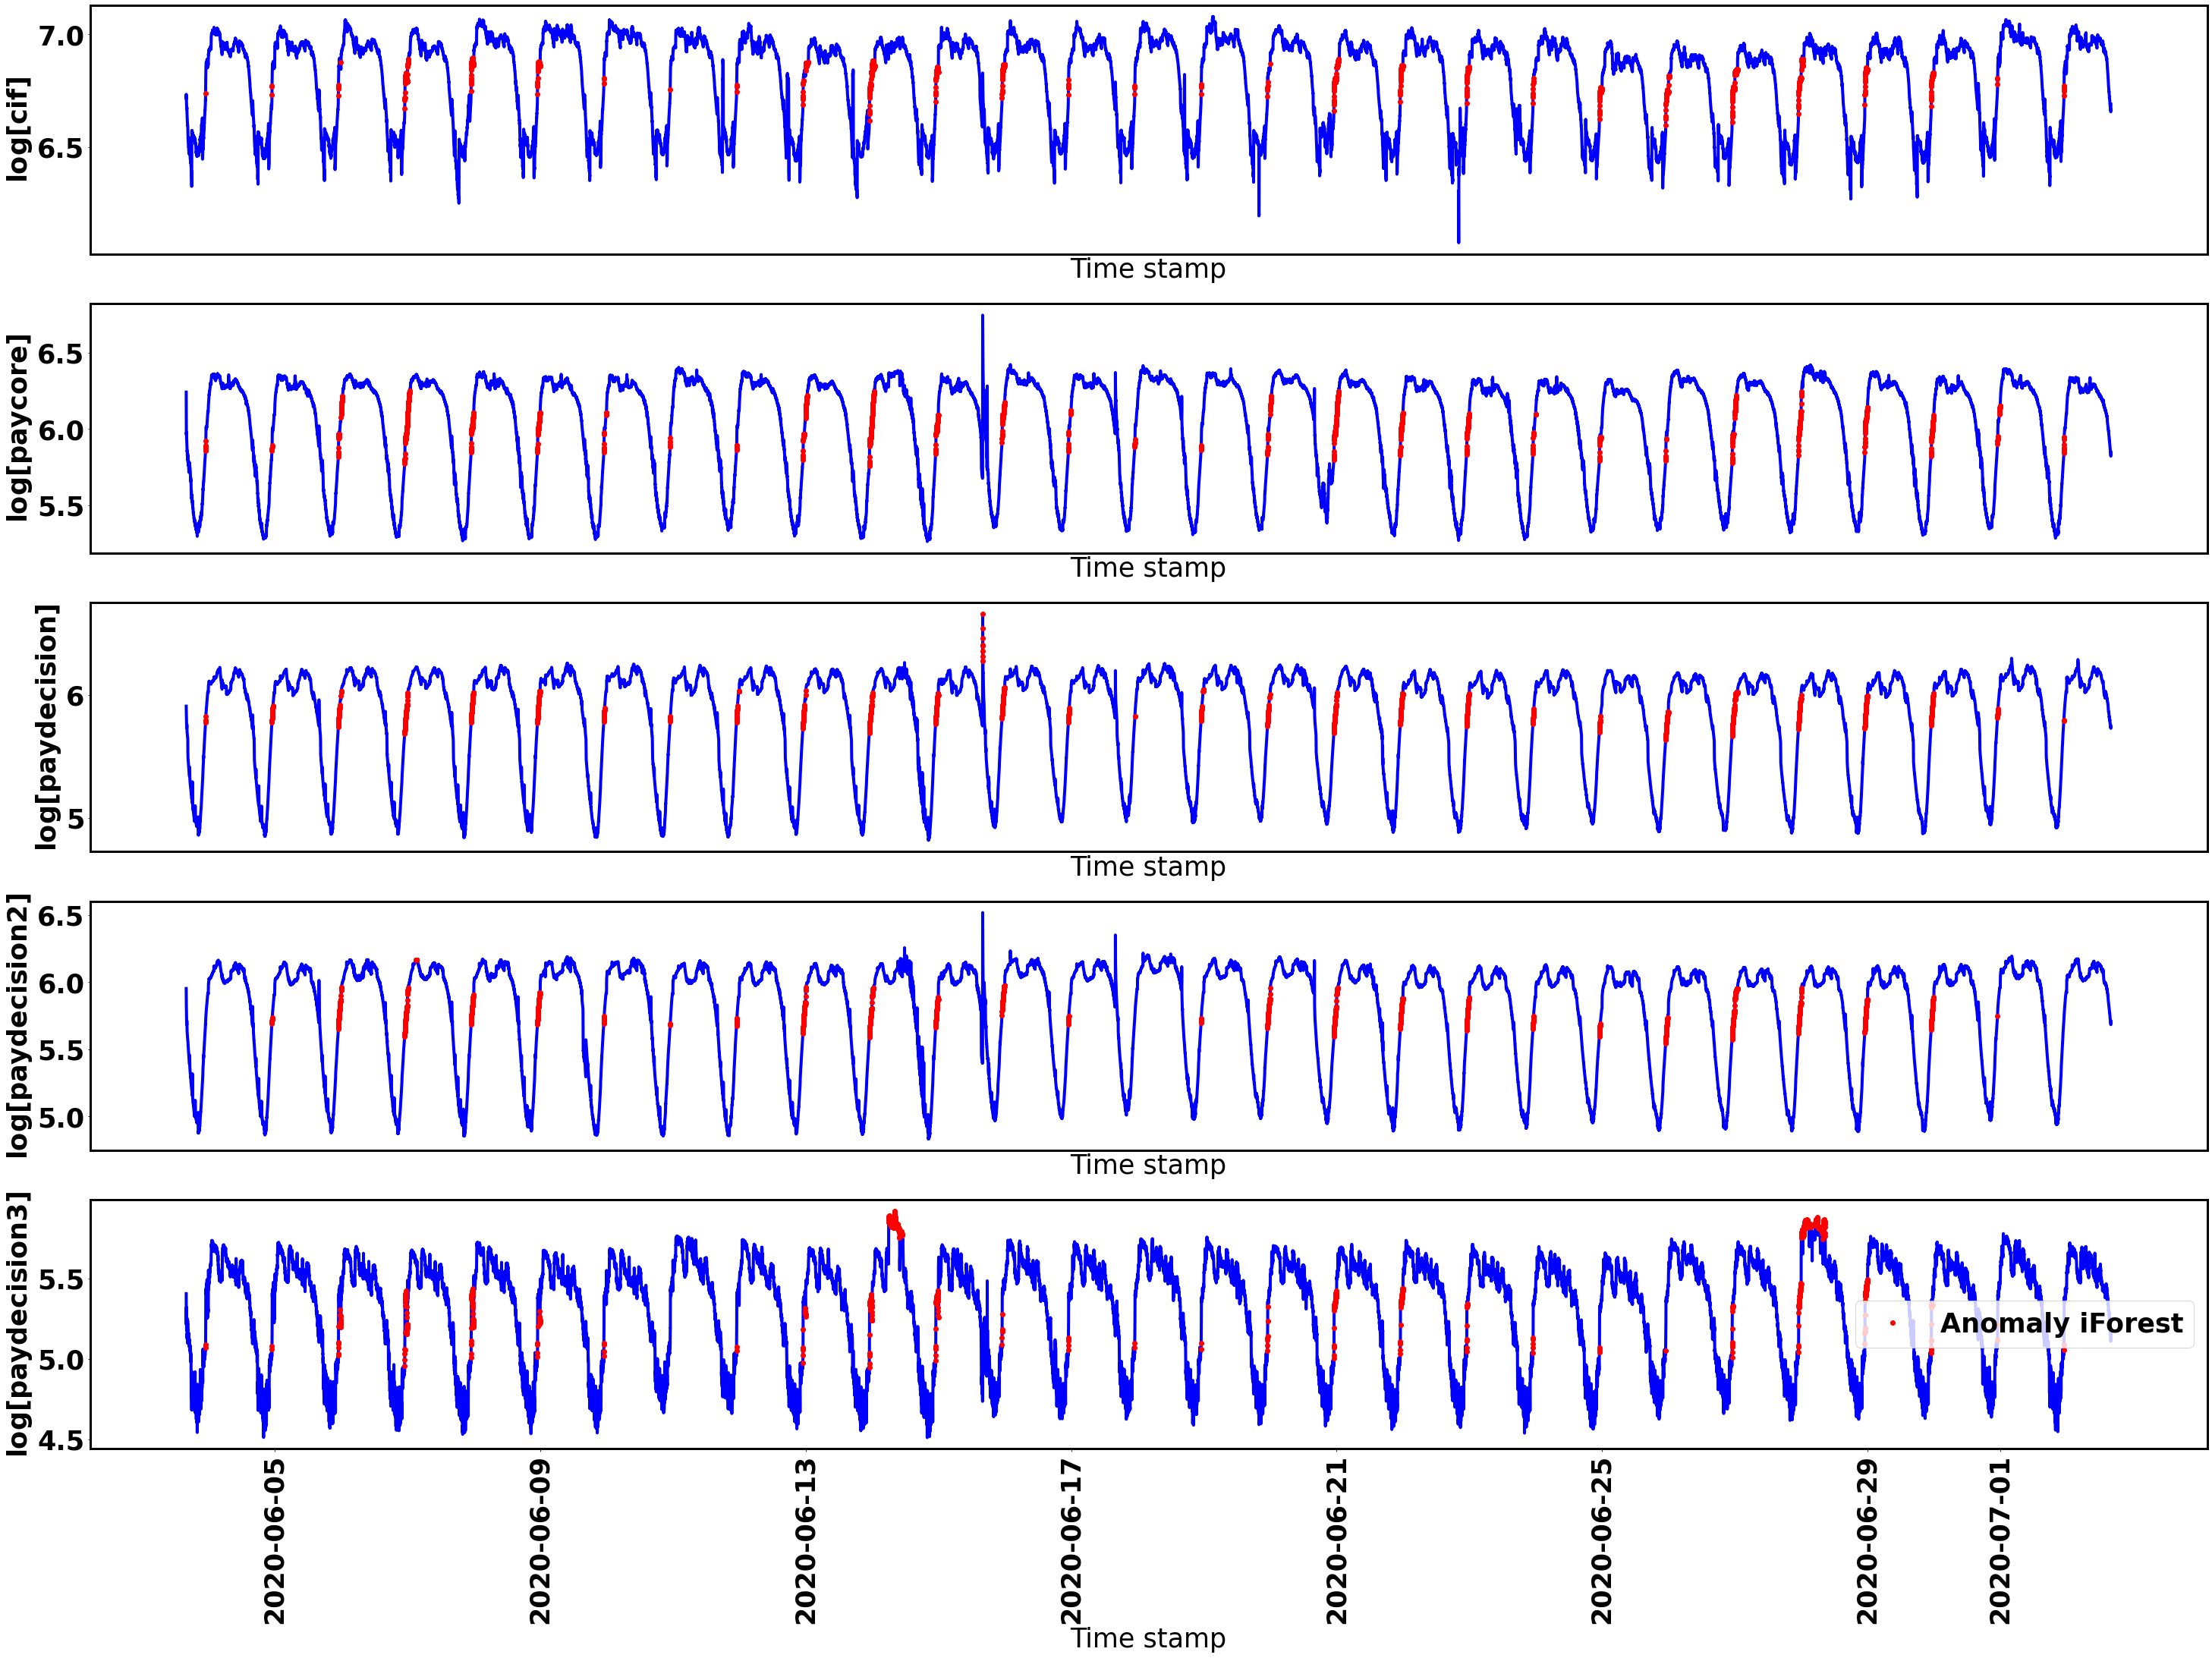

In [15]:
import gc


def log10(x):
    if x > 0:
        return math.log10(x)
    else:
        return -np.inf

    
## Some hyper-parameters:
outliers_fraction=0.03

# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
df['daylight'] = ((df['hours'] >= 7) & (df['hours'] <= 22)).astype(int)
df['DayOfTheWeek'] = df['time_stamp'].dt.dayofweek
df['WeekDay'] = (df['DayOfTheWeek'] < 5).astype(int)



font = {'family': 'normal','weight': 'bold',
        'size': 35}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)



for i in range(len(names_array)):
    plt.subplot(len(names_array),1,i+1)
    
    data = df[[names_array[i], 'hours', 'daylight', 'DayOfTheWeek', 'WeekDay']]
    # try use log?
    if False:
        temp = np.log10(data[names_array[i]])
        mask_inf = np.isinf(temp)
        temp[mask_inf]=-9999
        data[names_array[i]] = temp
    
    min_max_scaler = preprocessing.StandardScaler()

    # min-max scaler
    np_scaled = min_max_scaler.fit_transform(data)

    data = pd.DataFrame(np_scaled)

    # train Iforest 
    model =  IsolationForest(contamination = outliers_fraction)
    model.fit(data)
    # add the data to the main  
    df['anomaly_iforest_'+names_array[i]] = pd.Series(model.predict(data))
    df['anomaly_iforest_'+names_array[i]] = df['anomaly_iforest_'+names_array[i]].map( {1: 0, -1: 1} )
    print(names_array[i],df['anomaly_iforest_'+names_array[i]].value_counts())


    mask = df['anomaly_iforest_'+names_array[i]]==1

    plt.plot(df['time_stamp'],np.log10(df[names_array[i]]),"b",linewidth=4)

    plt.plot(df[mask]['time_stamp'],np.log10(df[mask][names_array[i]]),"ro",linewidth=4,label="Anomaly iForest")

    plt.xlabel("Time stamp")
    plt.ylabel(r"$\log [\rm %s]$"%names_array[i])

    if i<len(names_array)-1:
        plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    else:
        plt.xticks(rotation=90)
        
    gc.collect()


fig = matplotlib.pyplot.gcf()




fig.set_size_inches(50,35)
plt.legend()


save_path = plot_path + "Data_server_iForest" + ".png"

fig.savefig(save_path, dpi=200)




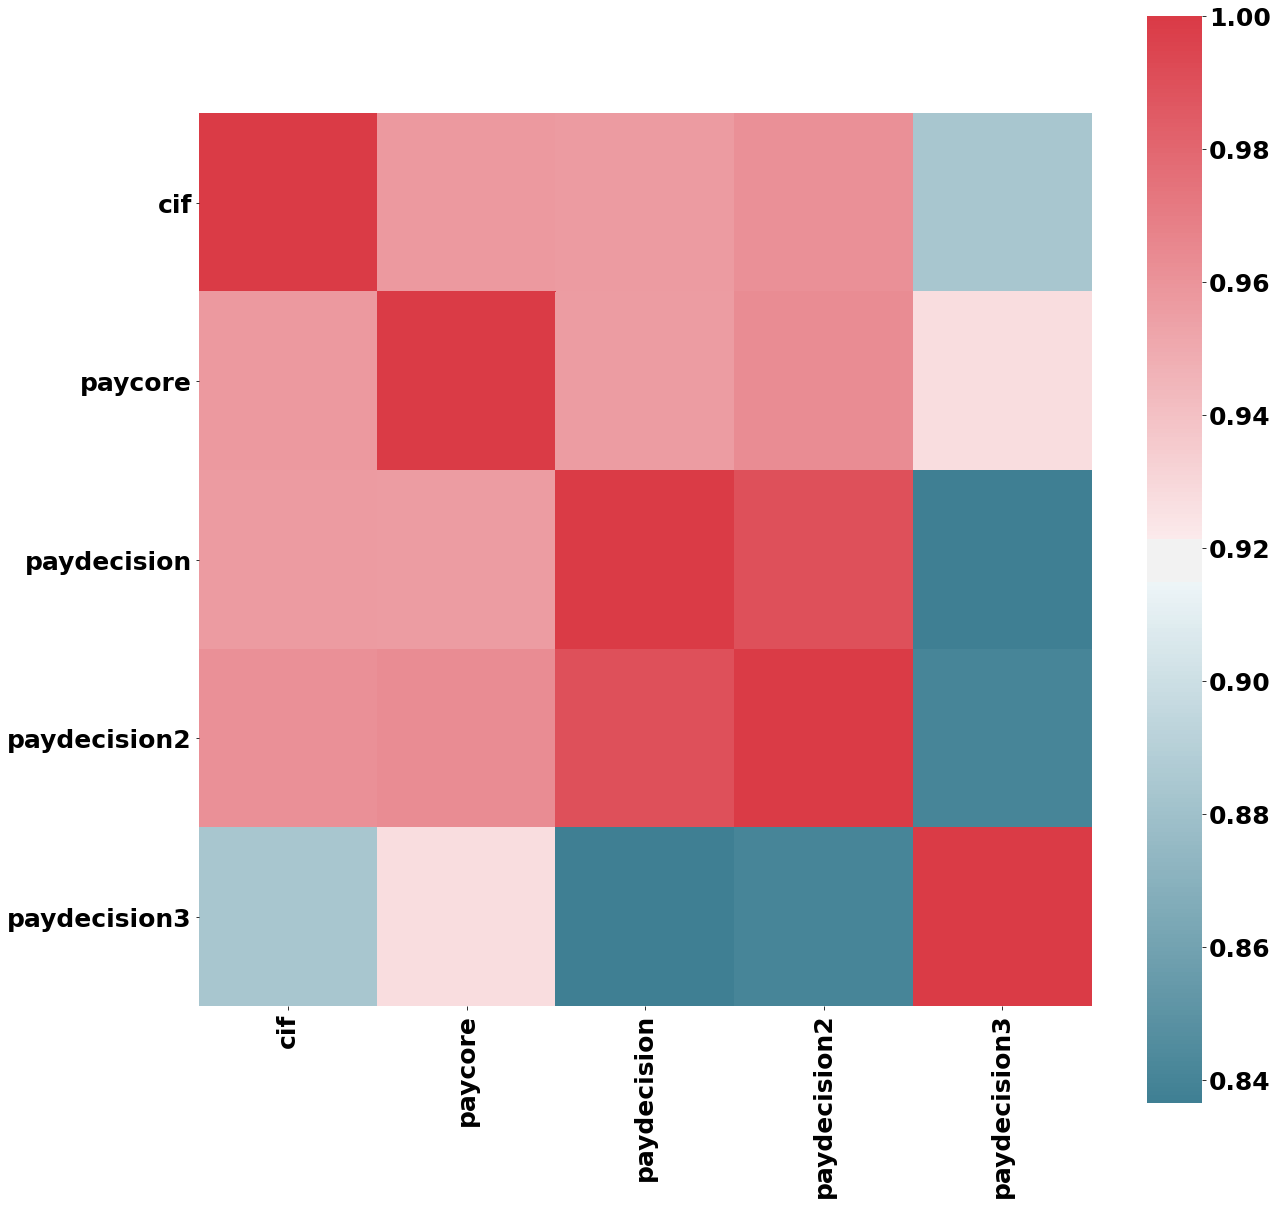

In [16]:
# Correlation between these diagnostic parameters:

import seaborn as sns


font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)




f, ax = plt.subplots()
corr = df[names_array].corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(20,20)
save_path = plot_path + "Correlation_v1" + ".png"

fig.savefig(save_path, dpi=150)




# Better model: LSTM/GRU based model
Refer: Stock Market Trend Analysis Using Hidden Markov Models https://arxiv.org/pdf/1311.4771.pdf <br>
We add our other dimensions : Open Close High Low to our dataset to improve performance of the model <br>
One small thing: You can replace LSTM with GRU to reduce 1/2 of the gate and improve training speed and have similar results <br>
DEEPAR from AWS is using the same idea: https://docs.aws.amazon.com/sagemaker/latest/dg/deepar.html <br>

In [17]:
if True:
    
    # calculate previous hour high low:
    # convert to seconds
    temp = df['time_stamp'] - min(df['time_stamp'])
    temp = temp.dt.total_seconds().astype(int)
    df["hours"] = temp//3600

    h_max = max(df["hours"])+1

    for n in range(len(names_array)):
        df[names_array[n]+"_open"] = df[names_array[n]]
        df[names_array[n]+"_close"] = df[names_array[n]]
        df[names_array[n]+"_max"] = df[names_array[n]]
        df[names_array[n]+"_min"] = df[names_array[n]]

    for j in range(1,h_max):
        mask_j = df["hours"]==j-1
        max_val = df[mask_j][names_array].max(axis=0).values
        min_val = df[mask_j][names_array].max(axis=0).values
        open_val = df[mask_j][names_array].values[0,:]
        close_val = df[mask_j][names_array].values[-1,:]
        mask_i = df["hours"]==j
        r = df[mask_i][names_array].shape[0]
        df.loc[mask_i,[r+"_open" for r in names_array]] = np.tile(open_val,(r,1))
        df.loc[mask_i,[r+"_close" for r in names_array]] = np.tile(close_val,(r,1))

        df.loc[mask_i,[r+"_max" for r in names_array]] = np.tile(max_val,(r,1))
        df.loc[mask_i,[r+"_min" for r in names_array]] = np.tile(min_val,(r,1))
    
    


names_array = list(df.keys())[1:]

In [18]:
df.head()

time_stamp        cif  paycore  paydecision  paydecision2  \
0 2020-06-03 16:00:00  5230362.0  1742333       810511        894642   
1 2020-06-03 16:01:00  5430718.0  1250771       732380        720773   
2 2020-06-03 16:02:00  5352478.0   998340       715939        691644   
3 2020-06-03 16:03:00  5247694.0   971876       701533        669921   
4 2020-06-03 16:04:00  5197260.0   926380       685236        649162   

   paydecision3  hours  days  hours_float  daylight  ...  paydecision_max  \
0        254995      0     3    16.000000         1  ...         810511.0   
1        213345      0     3    16.016667         1  ...         732380.0   
2        163959      0     3    16.033333         1  ...         715939.0   
3        165899      0     3    16.050000         1  ...         701533.0   
4        167605      0     3    16.066667         1  ...         685236.0   

   paydecision_min  paydecision2_open  paydecision2_close  paydecision2_max  \
0         810511.0           894642.0            894642.0          894642.0   
1         732380.0           720773.0            720773.0          720773.0   
2         715939.0           691644.0            691644.0          691644.0   
3         701533.0           669921.0            669921.0          669921.0   
4         685236.0           649162.0            649162.0          649162.0   

   paydecision2_min  paydecision3_open  paydecision3_close  paydecision3_max  \
0          894642.0           254995.0            254995.0          254995.0   
1          720773.0           213345.0            213345.0          213345.0   
2          691644.0           163959.0            163959.0          163959.0   
3          669921.0           165899.0            165899.0          165899.0   
4          649162.0           167605.0            167605.0          167605.0   

   paydecision3_min  
0          254995.0  
1          213345.0  
2          163959.0  
3          165899.0  
4          167605.0  

[5 rows x 37 columns]

In [22]:
df["minutes"]=df["time_stamp"].dt.hour*1440+df["time_stamp"].dt.hour*60+df["time_stamp"].dt.minute
# hyper-parameters:
# delta_t in minute,try a day first,output 5 dimensions
delta_t = 1440
n_epoch=10
n_cell = 50
# predict 1 minute for now
N_output=1
index_name= 0

checkpoint_path = "LSTM/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

min_max_scaler = preprocessing.StandardScaler()

name_mod = [names_array[index_name],names_array[index_name]+"_open",names_array[index_name]+"_close",names_array[index_name]+"_max",names_array[index_name]+"_min",]

np_scaled = min_max_scaler.fit_transform(df[name_mod])

df_scaled = pd.DataFrame(np_scaled,columns=name_mod)


X = np.zeros((df_scaled.shape[0]-delta_t,delta_t,5),dtype=float)
y = df_scaled[names_array[index_name]][delta_t:]

for i in range(len(y)):
    if i%10000==0:
        print("Prepare data %.2f percent"%(100*i/len(y)))
    X[i,:,:] = df_scaled[i:i+delta_t][name_mod].values

# split train test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

# Can also use GRU
model = tf.keras.Sequential([
  tf.keras.layers.LSTM(n_cell,input_shape=(X_train.shape[1],X_train.shape[2])),  # must declare input shape
  tf.keras.layers.Dense(1)
])

model.compile(loss='mae', optimizer='adam')
#model.summary()

callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)







Prepare data 0.00 percent
Prepare data 24.80 percent
Prepare data 49.60 percent
Prepare data 74.40 percent
Prepare data 99.20 percent


In [23]:

history = model.fit(X_train, y_train, epochs=n_epoch, batch_size=64, validation_data=(X_test, y_test),callbacks=[callback], verbose=1, shuffle=False)


Epoch 1/10
441/441 [==============================] - ETA: 0s - loss: 0.0710
Epoch 00001: saving model to LSTM/cp.ckpt
441/441 [==============================] - 39s 87ms/step - loss: 0.0710 - val_loss: 0.0331
Epoch 2/10
441/441 [==============================] - ETA: 0s - loss: 0.0309
Epoch 00002: saving model to LSTM/cp.ckpt
441/441 [==============================] - 37s 85ms/step - loss: 0.0309 - val_loss: 0.0284
Epoch 3/10
441/441 [==============================] - ETA: 0s - loss: 0.0258
Epoch 00003: saving model to LSTM/cp.ckpt
441/441 [==============================] - 39s 89ms/step - loss: 0.0258 - val_loss: 0.0255
Epoch 4/10
441/441 [==============================] - ETA: 0s - loss: 0.0228
Epoch 00004: saving model to LSTM/cp.ckpt
441/441 [==============================] - 39s 89ms/step - loss: 0.0228 - val_loss: 0.0217
Epoch 5/10
441/441 [==============================] - ETA: 0s - loss: 0.0213
Epoch 00005: saving model to LSTM/cp.ckpt
441/441 [==============================] 

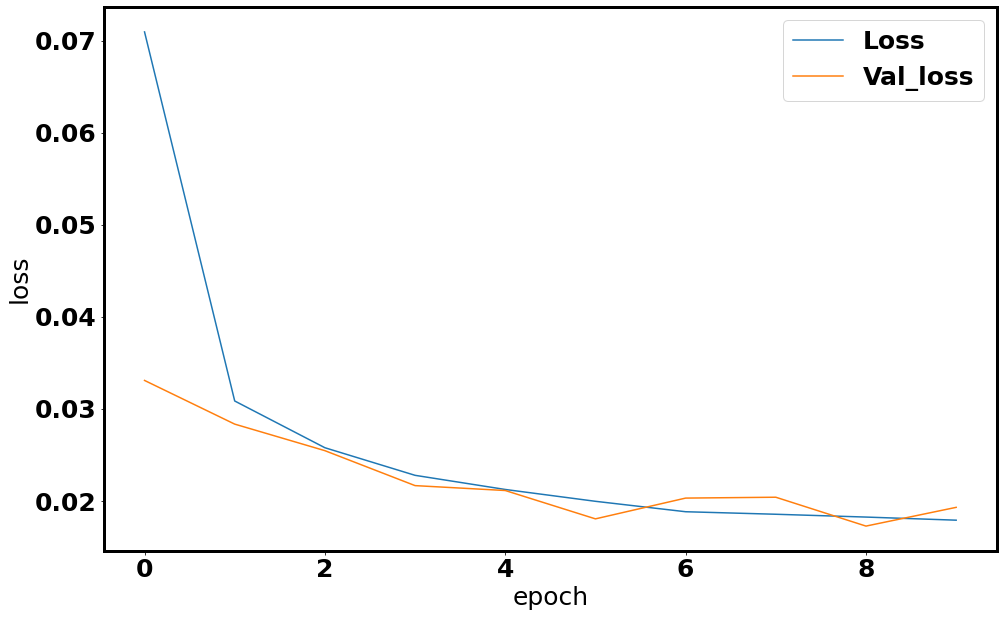

In [24]:
# Only for diagnostic

font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)



plt.plot(history.history['loss'],label="Loss")
plt.plot(history.history['val_loss'],label="Val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
fig = matplotlib.pyplot.gcf()


fig.set_size_inches(16,10)

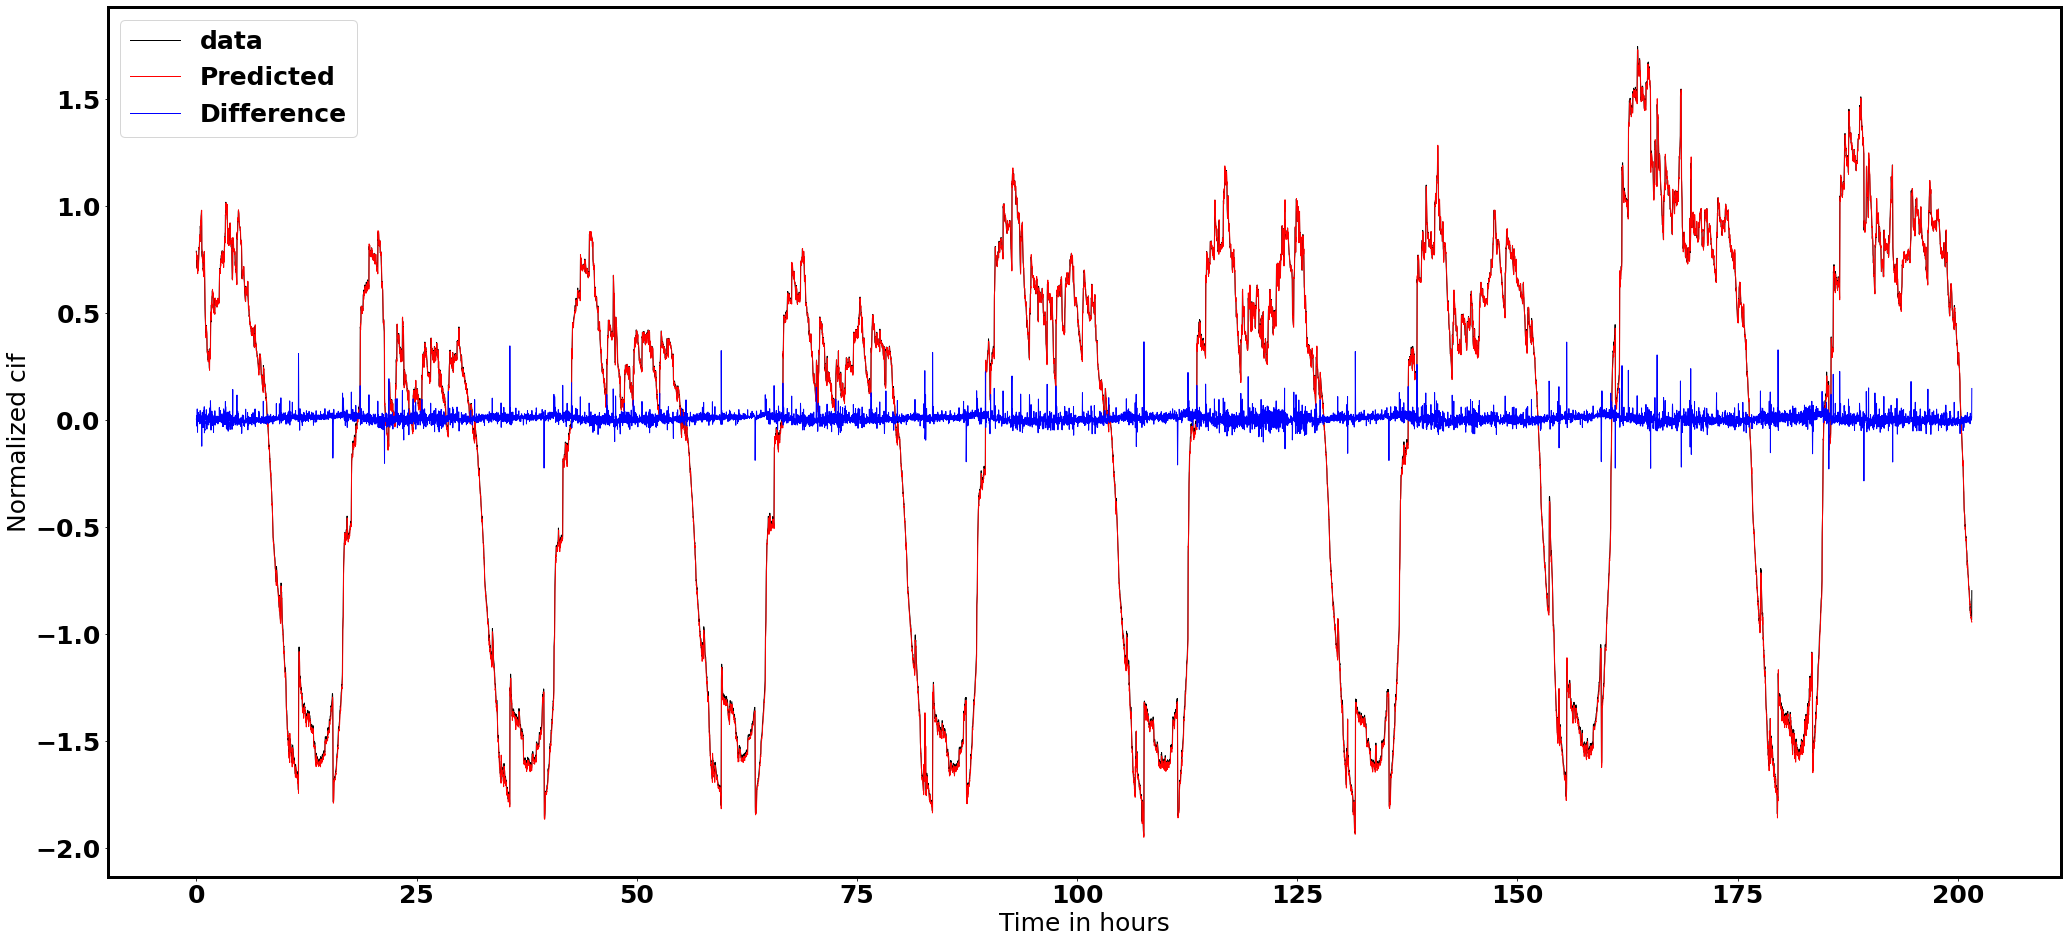

In [25]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
y_pre = model.predict(X_test)
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


timeline = np.arange(0,len(y_test),1)

plt.plot(timeline/60,y_test,"k",label="data",alpha=1,linewidth=1)
plt.plot(timeline/60,y_pre[:,0],"r",label="Predicted",alpha=1,linewidth=1)
plt.plot(timeline/60,y_test-y_pre[:,0],"b",label="Difference",alpha=1,linewidth=1)

plt.xlabel("Time in hours")
plt.ylabel("Normalized %s"%names_array[index_name])

plt.legend()

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "LSTM_results_5D" + ".png"

fig.savefig(save_path, dpi=150)








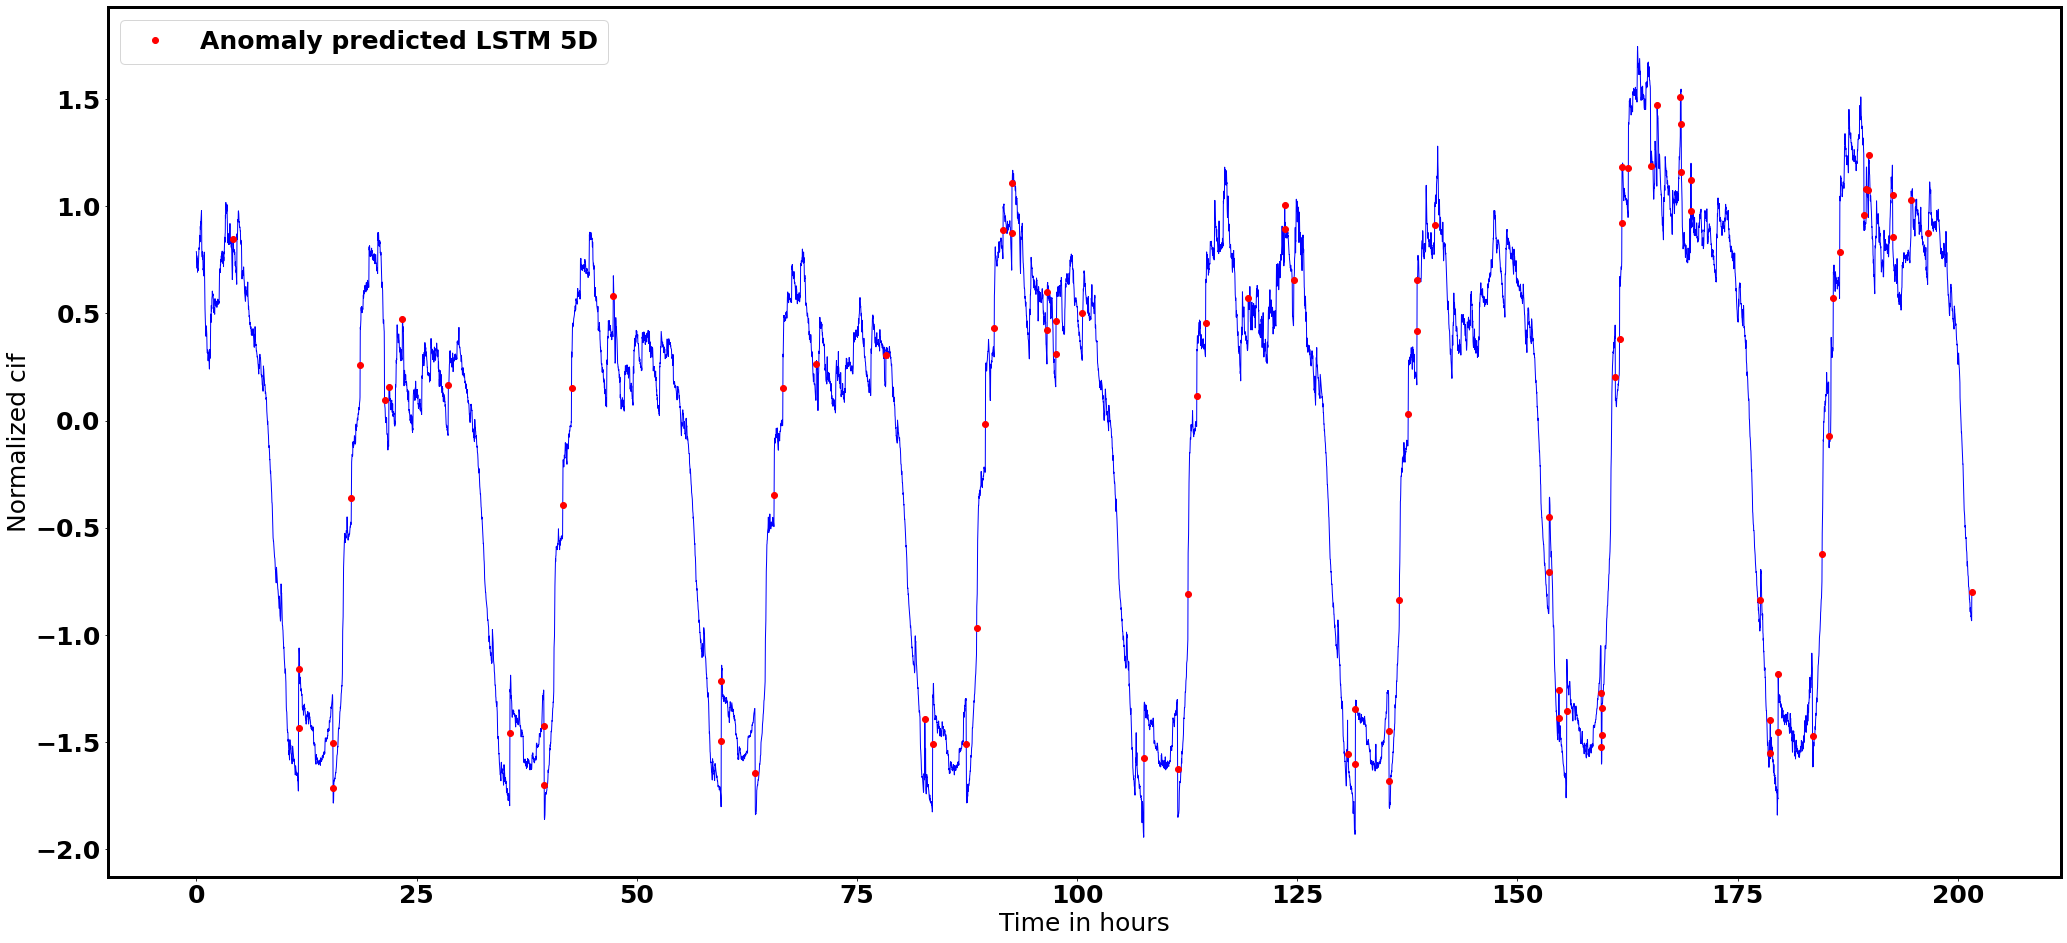

In [27]:
# Predict Anomaly using this rule: Bigger difference between data and prediction means anomaly

diff = y_test-y_pre[:,0]
anomaly_ratio = 0.008
mask = abs(diff)>np.nanpercentile(abs(diff),100-100*anomaly_ratio)



font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


timeline = np.arange(0,len(y_test),1)

plt.plot(timeline/60,y_test,"b",alpha=1,linewidth=1)
plt.plot(timeline[mask]/60,y_test[mask],"ro",label="Anomaly predicted LSTM 5D",alpha=1,linewidth=1)

plt.xlabel("Time in hours")
plt.ylabel("Normalized %s"%names_array[index_name])

plt.legend()

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "LSTM_anomaly_prediction_5D" + ".png"

fig.savefig(save_path, dpi=150)









# Next step: Classifier-Regressor Transformer:
Since we also want to develop a model that can predict the trend (Not for anomaly detection only), we try a modified version of Transformer <br>
The front is a classifier, since any NN model has the highest efficiency at classifier mode rather than regressor mode. <br>
Use interpolation to convert input into integer, since we can interpolate them into a lot of ints, we expect a very low loss in precision Regressor for output. <br>

In [3]:
# scale dot attention:
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    # Dimension of k
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  
    # calculate attention weight:
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

# Multi-head Attention:
# This is what we use
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        
        # Always use Super to inheriatte and avoid extra code.
        assert d_model%num_heads==0
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        # sanity check:
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        # Q K W:
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
    def split_heads(self, x, batch_size):
        # Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        # https://www.tensorflow.org/api_docs/python/tf/transpose : perm
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        return output, attention_weights
    
    
        
        



In [4]:
## Encoder decoder for Time series:

# pointwise feed forward network
def point_wise_feed_forward_network(d_model, dff):
    # Two FC layers:
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

# Change embedding since it's not int anymore:
class EmbeddingLayer(tf.keras.layers.Layer):
    def __init__(self,embedding_size):
        super(EmbeddingLayer,self).__init__()
        self.embedding_size=embedding_size

    def build(self,input_shape):
        with tf.name_scope('embedding'):
            self.shared_weights=self.add_weight(name='weights',
                                                shape=[input_shape[-1],self.embedding_size],
                                                initializer=tf.random_normal_initializer(mean=0.,
                                                                                         stddev=self.embedding_size ** -0.5))
        super(EmbeddingLayer,self).build(input_shape)


    def call(self,x):
        y=tf.einsum('bsf,fk->bsk',x,self.shared_weights)
        return y
    

class EncoderLayer(tf.keras.layers.Layer):
    # Here we use a 0.1 dropout rate as default
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
        return out2
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(tf.random.uniform((64, 43, 512)), False, None)

print(sample_encoder_layer_output.shape)  # (batch_size, input_seq_len, d_model)

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

print(sample_decoder_layer_output.shape)  # (batch_size, target_seq_len, d_model)
    

(64, 43, 512)
(64, 50, 512)


In [5]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                              np.arange(d_model)[np.newaxis, :],
                              d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
    
        # adding embedding and position encoding.
        #print("Check",x.shape)
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        #x = tf.keras.layers.Dense(self.d_model)(x)
        #print("check 2",x.shape)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        #print("check 3",x.shape)

        x = self.dropout(x, training=training)
        #print("check 4",x.shape)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x  # (batch_size, input_seq_len, d_model)
    
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        #x = tf.keras.layers.Dense(self.d_model)(x)
        
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights
    

In [6]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_seq_size, 
               output_seq_size, input_delta_t, output_delta_t, rate=0.1):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                               input_seq_size, input_delta_t, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                               output_seq_size, output_delta_t, rate)

        self.final_layer = tf.keras.layers.Dense(1)
        # Add a Gaussian noist layer if you want the error bar.


    def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
        #print("check encoder size",enc_output.shape)

    
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        
        #print("check decoder size",dec_output.shape)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights



In [7]:
# We encoder the float32 input to input_seq_size/output_seq_size integers
# The output is a sliding time table for different time scale prediction:
# Eg: you need to make sure your prediction delta_t<output delta_t and input data delta_t < input_delta_t
# For GTX 1060 we can set batch=16 and use 4X batch size for Tesla P40

batch = 8

sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_seq_size=1000, output_seq_size=1000, 
    input_delta_t=1440, output_delta_t=240)

# input: batch+sequence length
# biggest length for in/out put is pe_input,  pe_target
temp_input = tf.random.uniform((batch, 720), dtype=tf.int64, minval=0, maxval=1000)
temp_target = tf.random.uniform((batch, 3), dtype=tf.int64, minval=0, maxval=1000)

#temp_input = tf.cast(temp_input,dtype=tf.float32)
#temp_target = tf.cast(temp_target,dtype=tf.float32)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

print("final output size",fn_out.shape)  # (batch_size, tar_seq_len, target_vocab_size)

final output size (8, 3, 1)


In [8]:
# prepare data: fow now I only use 1D data, but it can be extended to multiple channel:
# Load data:names_array


temp = df["cif"]
# Normalize to 0-1000

temp = (temp-min(temp))/(max(temp)-min(temp))

lower, upper = 0, 999
temp = [lower + (upper - lower) * x for x in temp]
temp = np.array(temp,dtype=int)
delta_t = 720
delta_t_out = 3


X = np.zeros((temp.shape[0]-delta_t-delta_t_out,delta_t,1),dtype=int)

for i in range(delta_t_out):
    if i==0:
        y = temp[delta_t:-delta_t_out]
    else:
        y = np.c_[y,temp[delta_t+i:-(delta_t_out-i)]]
    
    
for i in range(y.shape[0]):
    if i%10000==0:
        print("Prepare data %.2f percent"%(100*i/len(y)))
    X[i,:,:] = np.atleast_2d(temp[i:i+delta_t]).T


train_dataset_TS = tf.data.Dataset.from_tensor_slices((X,y))

Prepare data 0.00 percent
Prepare data 24.37 percent
Prepare data 48.74 percent
Prepare data 73.10 percent
Prepare data 97.47 percent


Text(0.5, 0, 'Train Step')

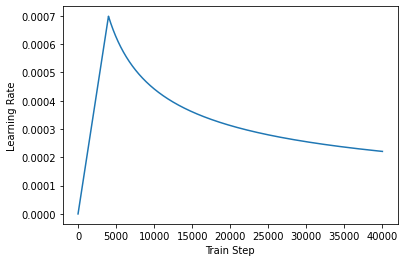

In [9]:
## Optimizor:
import matplotlib.pyplot as plt

d_model=512

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
    
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)
# Learning rate curve:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [10]:
# Loss function:
# loss and metric

# For now I use sparse-cross entropy. But MAE may make more sense here:

loss_object = tf.keras.losses.MeanSquaredError(reduction='none')


def loss_function(real, pred):
    #mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    #mask = tf.cast(mask, dtype=loss_.dtype)
    #loss_ *= mask
  
    return tf.reduce_sum(loss_)/tf.cast(len(loss_),dtype=tf.float32)




train_loss = tf.keras.metrics.Mean(name='train_loss')


train_accuracy = tf.keras.metrics.MeanSquaredError(name='mean_squared_error',dtype=tf.float32)



# Optional
#train_accuracy = tf.keras.metrics.MeanSquaredError(name='train_MSE')








In [11]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by 
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

      
    return enc_padding_mask, combined_mask, dec_padding_mask

In [12]:




batch = 8

transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_seq_size=1000, output_seq_size=1000, 
    input_delta_t=2400, output_delta_t=300)



# save file: optional
import os

checkpoint_path = "checkpoints/train_TS_CIF"
os.system("mkdir %s"%checkpoint_path)

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')



train_step_signature = [
        tf.TensorSpec(shape=(None, None), dtype=tf.int64),
        tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    ]

@tf.function(input_signature=train_step_signature)

def train_step(inp, tar):
        
    tar_inp = tar
    tar_real = tar

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    with tf.GradientTape() as tape:
        # No mask for now : Optional
        enc_padding_mask, combined_mask, dec_padding_mask = None,None,None
        predictions, _ = transformer(inp, tar_inp, True, enc_padding_mask, combined_mask, dec_padding_mask)
        predictions = predictions[:,:,0]
        loss = loss_function(tar_real, predictions)
        ## Optional: Add MSE error term. Since the number in SCCE doesn't make sense. Add MSE to punish far away dots like 0 and 999
        #predictions_id = tf.argmax(predictions, axis=-1)
        #loss+=float(tf.reduce_sum(tf.keras.losses.MSE(tar,predictions_id))/(10000*batch))
        #value = float(tf.reduce_sum(tf.keras.losses.MSE(tar,predictions_id))/(1*batch))
        # Avoid gradient exploding
        """
        if not loss>0:
            value=float(100000)
        loss+=value
        
        """
        
        
        # Or we can only use MSE loss.
        
    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)



In [ ]:



#Train and save:

import time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

# We only train 5-10 epochs since it's only for showcase, you should train longer for production
EPOCHS = 10
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))
batch=16

N = len(y_train)

for epoch in range(EPOCHS):
    start = time.time()
  
    train_loss.reset_states()
    train_accuracy.reset_states()
    for i in range(N//batch):
        inp, tar=X_train[batch*i:min(batch*i+batch,N),:,0],y_train[batch*i:min(batch*i+batch,N)]
        tar = np.atleast_2d(tar)
        lo = train_step(inp, tar)
        if i%500==0 and epoch%2==0:
            # ckpt_save_path = ckpt_manager.save()
            # optional:
            # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
            
            print("Doing %d (%d) batch in epoch %d "%(i,N//batch,epoch))

            #print("Loss",train_loss.result(), "MSE",train_accuracy.result())
            print("MSE",train_accuracy.result())
    
  

Doing 0 (1795) batch in epoch 0 
MSE tf.Tensor(406562.03, shape=(), dtype=float32)


In [ ]:
# testing:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
N_test = len(y_test)


for i in range(N_test//batch):
    if i%200==0:
            print("Doing %d (%d)"%(i,N_test//batch))
    
    inp, tar=X_test[batch*i:min(batch*i+batch,N),:,0],y_test[batch*i:min(batch*i+batch,N)]
    tar = tar
    tar_inp = tar
    tar_real = tar

    # enc_padding_mask, combined_mask, dec_padding_mask = None,None,None
    
    predictions, attention_weights = transformer(inp, 
                                                 tar,
                                                 False,
                                                 None,None,None)
    if i==0:
        y_pred_all = predictions
    else:
        y_pred_all = np.r_[y_pred_all,predictions]


    
y_pred_all = np.array(y_pred_all)

print("Train+Test all set!")

In [ ]:
# plot:
y_test = y_test[:y_pred_all.shape[0]]
import matplotlib
from matplotlib.pylab import rc


font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)

plt.plot(y_test[:3000,0],"k",label="Data")
plt.plot(np.nanmedian(y_pred_all[:3000],axis=1),"r",label="Prediction-Transformer-3")
diff = y_test[:3000,0]-np.nanmedian(y_pred_all[:3000],axis=1)
plt.plot(diff,"b",label="Difference")

plt.xlabel("Time")
plt.ylabel(r"CIF")
plt.suptitle("Value vs day")

fig = matplotlib.pyplot.gcf()
plt.legend()

fig.set_size_inches(35,12)

save_path = plot_path + "Transformer_CIF_short" + ".png"

fig.savefig(save_path, dpi=200)






In [ ]:
# Anomaly detection:
ratio = 0.01

y_test = y_test[:y_pred_all.shape[0]]
import matplotlib
from matplotlib.pylab import rc


font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)

x_target = np.arange(0,3000,1)

plt.plot(x_target,y_test[:3000,0],"b",label="Data")
diff = y_test[:3000,0]-np.nanmedian(y_pred_all[:3000],axis=1)
mask = abs(diff)>np.percentile(abs(diff),100-100*ratio*2)

plt.plot(x_target[mask],y_test[:3000,0][mask],"ro",label="Prediction-Transformer-3-Anomaly")

plt.xlabel("Time")
plt.ylabel(r"CIF")
plt.suptitle("Value vs day")

fig = matplotlib.pyplot.gcf()
plt.legend()

fig.set_size_inches(35,12)

save_path = plot_path + "Transformer_CIF_short_anomaly" + ".png"

fig.savefig(save_path, dpi=200)







# Classifier-Regressor-Transformer for long term prediction

In [ ]:
# Let's do some lone term prediction like 60 minutes?

# You need to re-train the model since this model is only for short-term.





batch = 8

transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_seq_size=1000, output_seq_size=1000, 
    input_delta_t=2400, output_delta_t=300)



# save file: optional
import os

checkpoint_path = "checkpoints/train_TS_CIF"
os.system("mkdir %s"%checkpoint_path)

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')



train_step_signature = [
        tf.TensorSpec(shape=(None, None), dtype=tf.int64),
        tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    ]

@tf.function(input_signature=train_step_signature)

def train_step(inp, tar):
        
    tar_inp = tar
    tar_real = tar

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    with tf.GradientTape() as tape:
        # No mask for now : Optional
        enc_padding_mask, combined_mask, dec_padding_mask = None,None,None
        predictions, _ = transformer(inp, tar_inp, True, enc_padding_mask, combined_mask, dec_padding_mask)
        predictions = predictions[:,:,0]
        loss = loss_function(tar_real, predictions)
        ## Optional: Add MSE error term. Since the number in SCCE doesn't make sense. Add MSE to punish far away dots like 0 and 999
        #predictions_id = tf.argmax(predictions, axis=-1)
        #loss+=float(tf.reduce_sum(tf.keras.losses.MSE(tar,predictions_id))/(10000*batch))
        #value = float(tf.reduce_sum(tf.keras.losses.MSE(tar,predictions_id))/(1*batch))
        # Avoid gradient exploding
        """
        if not loss>0:
            value=float(100000)
        loss+=value
        
        """
        
        
        # Or we can only use MSE loss.
        
    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)


















In [ ]:
# prepare data: fow now I only use 1D data, but it can be extended to multiple channel:
# Load data:names_array


temp = df["cif"]
# Normalize to 0-1000

temp = (temp-min(temp))/(max(temp)-min(temp))

lower, upper = 0, 999
temp = [lower + (upper - lower) * x for x in temp]
temp = np.array(temp,dtype=int)
delta_t = 720
delta_t_out = 60


X = np.zeros((temp.shape[0]-delta_t-delta_t_out,delta_t,1),dtype=int)

for i in range(delta_t_out):
    if i==0:
        y = temp[delta_t:-delta_t_out]
    else:
        y = np.c_[y,temp[delta_t+i:-(delta_t_out-i)]]
    
    
for i in range(y.shape[0]):
    if i%10000==0:
        print("Prepare data %.2f percent"%(100*i/len(y)))
    X[i,:,:] = np.atleast_2d(temp[i:i+delta_t]).T


train_dataset_TS = tf.data.Dataset.from_tensor_slices((X,y))

In [ ]:



#Train and save:

import time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

EPOCHS = 20
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))
batch=4

N = len(y_train)

for epoch in range(EPOCHS):
    start = time.time()
  
    train_loss.reset_states()
    train_accuracy.reset_states()
    for i in range(N//batch):
        inp, tar=X_train[batch*i:min(batch*i+batch,N),:,0],y_train[batch*i:min(batch*i+batch,N)]
        tar = np.atleast_2d(tar)
        lo = train_step(inp, tar)
        if i%500==0 and epoch%2==0:
            # ckpt_save_path = ckpt_manager.save()
            # optional:
            # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
            
            print("Doing %d (%d) batch in epoch %d "%(i,N//batch,epoch))

            #print("Loss",train_loss.result(), "MSE",train_accuracy.result())
            print("MSE",train_accuracy.result())
    
  

In [ ]:
# testing:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)


N_test = len(y_test)


for i in range(N_test//batch):
    if i%200==0:
            print("Doing %d (%d)"%(i,N_test//batch))
    
    inp, tar=X_test[batch*i:min(batch*i+batch,N),:,0],y_test[batch*i:min(batch*i+batch,N)]
    tar = tar
    tar_inp = tar
    tar_real = tar

    # enc_padding_mask, combined_mask, dec_padding_mask = None,None,None
    
    predictions, attention_weights = transformer(inp, 
                                                 tar,
                                                 False,
                                                 None,None,None)
    if i==0:
        y_pred_all = predictions
    else:
        y_pred_all = np.r_[y_pred_all,predictions]


    
y_pred_all = np.array(y_pred_all)

print("Train+Test all set!")

In [ ]:
# sample every 60 dots :)
y_pred_1d = y_pred_all[np.arange(0,y_pred_all.shape[0],60),:]



In [ ]:
# plot:
y_test = y_test[:y_pred_all.shape[0]]
import matplotlib
from matplotlib.pylab import rc


font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)

plt.plot(y_test[:3000,0],"k",label="Data")
plt.plot(y_pred_1d.ravel()[:3000],"r",label="Prediction-Transformer-60")
diff = y_test[:3000,0]-y_pred_1d.ravel()[:3000]
plt.plot(diff,"b",label="Difference")

plt.xlabel("Time")
plt.ylabel(r"CIF")
plt.suptitle("Value vs day")

fig = matplotlib.pyplot.gcf()
plt.legend()

fig.set_size_inches(35,12)

save_path = plot_path + "Transformer_CIF_long" + ".png"

fig.savefig(save_path, dpi=200)







In [ ]:
print("All Set")

# To be continue: Can we predict the Trend and amplitude separately?
Use DQN+Transforemr to predict Trend and amplitude separately